# Test Parallel ExIFFI

Host capri Davide

    Hostname capri.dei.unipd.it
    User p1026u27

In [1]:
import sys
import numpy as np
import pandas as pd
from tqdm import trange
from append_dir import append_dirname
append_dirname('ExIFFI')
from utils.utils import partition_data
from utils.feature_selection import *
#from plot import *
#from simulation_setup import *
from models import *
from models.Extended_IF import *
from models.Extended_DIFFI_parallel import *
from models.Extended_DIFFI_original import *
import math
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
import time

import os
import pickle 
from scipy.io import loadmat
from glob import glob

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

## Set up file paths

In [ ]:
path = os.getcwd()
path = os.path.dirname(path)
path_real = os.path.join(path, "data", "real")
mat_files_real = glob(os.path.join(path_real, "*.mat"))
mat_file_names_real = {os.path.basename(x).split(".")[0]: x for x in mat_files_real}
csv_files_real = glob(os.path.join(path_real, "*.csv"))
csv_file_names_real = {os.path.basename(x).split(".")[0]: x for x in csv_files_real}
dataset_names = list(mat_file_names_real.keys()) + list(csv_file_names_real.keys())
mat_file_names_real.update(csv_file_names_real)
dataset_paths = mat_file_names_real.copy()

## Utility Functions

Drop Duplicates from the loaded dataset 

In [16]:
def drop_duplicates(X, y):
    S = np.c_[X, y]
    S = pd.DataFrame(S).drop_duplicates().to_numpy()
    X, y = S[:, :-1], S[:, -1]
    return X, y

Load dataset coming from a `.mat` file 

In [17]:
def load_data(path):
    data = loadmat(path)
    X, y = data["X"], data["y"]
    y = np.hstack(y)
    X, y = drop_duplicates(X, y)
    return X, y

Load dataset coming from a `.csv` file

In [18]:
def load_data_csv(path):
    data = pd.read_csv(path, index_col=0)
    if "Unnamed: 0" in data.columns:
        data = data.drop(columns=["Unnamed: 0"])

    X = data[data.columns[data.columns != "Target"]]
    y = data["Target"]

    X, y = drop_duplicates(X, y)

    return X, y

Load the data (with `load_data` or with `load_data_csv`), scale the data and split it into train and test set obtaining `X_train`, `X_test` that will be passed to `compute_imps`. 

In [19]:
def pre_process(path):
    extension = os.path.splitext(path)[1]

    if extension == ".csv":
        X, y = load_data_csv(path)
    elif extension == ".mat":
        X, y = load_data(path)
    else:
        raise ValueError("Extension not supported")

    X_train, X_test = partition_data(X, y)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_test = np.r_[X_train, X_test]

    return X_train, X_test

Compute the Global Importance of a given dataset `n_runs` times. At the end a matrix with shape `(n_runs, n_features)` is returned. Each row contains the global importance of the features for a given run.

In [20]:
def compute_imps(model, X_train, X_test, n_runs):

    X_test=np.r_[X_train,X_test]

    imps = np.zeros(shape=(n_runs, X_train.shape[1]))
    for i in tqdm(range(n_runs)):
        model.fit(X_train)
        imps[i, :] = model.Global_importance(
            X_test, calculate=True, overwrite=False, depth_based=False
        )

    return imps

### `test_exiffi`

This is the function called in the `main` of `test_parallel.py` used to do the experiments on the CAPRI HPC server. For a given set of datasets it computes the global importance `n_runs` times using `Extended_DIFFI_parallel` or `Extended_DIFFI_original`and saves the importances matrices, the time stats obtained and the test arguments in a `.npz` file.

#### `test_exiffi` Parameters

- `X_train`: the train set
- `X_test`: the test set
- `savedir`: directory where to save the results in `.npz` format
- `n_runs`: number of runs to do
- `seed`: random seed to obtain reproducibile results and compare the importances matrices obtaind from the parallel and the serial version of the algorithm (they must be the same to certify the correctness of the parallel version)
- `parallel`: Boolean variable used to choose between the parallel and the serial version of the algorithm
- `n_cores`: Number of threads to use in the parallel version of the algorithm. This coincides with the number of cores set with the `--cpus-per-task` options in the `.job` file
- `num_trees`: Number of trees used by ExIFFI. The higher the more complex and more computationally expensive the algorithm is
- `name`: Name of the dataset

In [8]:
def test_exiffi(
    X_train,
    X_test,
    savedir,
    n_runs=10,
    seed=None,
    parallel=False,
    n_cores=2,
    num_trees=300,
    name="",
):
    args_to_avoid = ["X_train", "X_test", "savedir", "args_to_avoid", "args"]
    args = dict()
    for k, v in locals().items():
        if k in args_to_avoid:
            continue
        args[k] = v

    ex_time = []
    ex_imps = {}

    for i in trange(n_runs):
        seed = None if seed is None else seed + i

        if parallel:
            EDIFFI = Extended_DIFFI_parallel(
                n_trees=num_trees, max_depth=100, subsample_size=256, plus=1, seed=seed
            )
            EDIFFI.set_num_processes(n_cores, n_cores)
        else:
            EDIFFI = Extended_DIFFI_original(
                n_trees=num_trees, max_depth=100, subsample_size=256, plus=1, seed=seed
            )

        start = time.time()
        imps = compute_imps(EDIFFI, X_train, X_test, 10)
        ex_imps["Execution " + str(i)] = imps
        end = time.time()
        ex_time.append(end - start)

    # print(ex_imps)
    time_stat = {"mean": np.mean(ex_time), "std": np.std(ex_time)}
    filename = "test_stat_parallel.npz" if parallel else "test_stat_serial.npz"
    t = time.localtime()
    current_time = time.strftime("%d-%m-%Y_%H-%M-%S", t)
    filename = current_time + "_" + name + "_" + filename

    # if dir does not exist, create it
    if not os.path.exists(savedir):
        os.makedirs(savedir)
    filepath = os.path.join(savedir, filename)

    np.savez(
        filepath,
        execution_time_stat=time_stat,
        importances_matrix=ex_imps,
        arguments=args,
    )

## Load Data

## Wine Dataset

In [9]:
name='wine'
X,y=load_data(dataset_paths[name])
X_train,X_test=partition_data(X,y)
X.shape,y.shape

((129, 13), (129,))

### Serial ExIFFI

In [13]:
test_exiffi(
    X_train=X_train,
    X_test=X_test,
    savedir='../results/npz',
    n_runs=1,
    seed=120,
    parallel=False,
    n_cores=12,
    num_trees=10,
    name=name,
)

100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


### Parallel ExIFFI

In [ ]:
test_exiffi(
    X_train=X_train,
    X_test=X_test,
    savedir='../results/npz',
    n_runs=1,
    seed=120,
    parallel=True,
    n_cores=12,
    num_trees=200,
    name=name,
)

## Ionosphere Dataset

In [12]:
name='ionosphere'
X,y=load_data(dataset_paths[name])
X_train,X_test=partition_data(X,y)
X.shape,y.shape

((350, 33), (350,))

### Serial ExIFFI

In [ ]:
test_exiffi(
    X_train=X_train,
    X_test=X_test,
    savedir='../results/npz',
    n_runs=1,
    seed=120,
    parallel=False,
    n_cores=12,
    num_trees=10,
    name=name,
)

### Parallel ExIFFI

In [ ]:
test_exiffi(
    X_train=X_train,
    X_test=X_test,
    savedir='../results/npz',
    n_runs=1,
    seed=120,
    parallel=True,
    n_cores=12,
    num_trees=200,
    name=name,
)

## Moodify Dataset

In [26]:
name='moodify'
X,y=load_data_csv(dataset_paths[name])
X_train,X_test=partition_data(X,y)
X.shape,y.shape

((276260, 11), (276260,))

# Test Results 

## Parallel

In [9]:
stats=np.load('26-01-2024_17-42-35_test_stat_parallel_7000.npz',allow_pickle=True)
data_parallel=stats['importances_matrix'].tolist()
time_data_parallel=stats['execution_time_stat']
arguments_parallel=stats['arguments'].tolist()

In [12]:
print(arguments_parallel.keys())

args_to_avoid = ["X_train", "X_test", "X"]
for key in arguments_parallel.keys():
    if key not in args_to_avoid:
        print(key,arguments_parallel[key])

dict_keys(['X_train', 'X_test', 'X', 'n_runs', 'seed', 'parallel', 'n_cores'])
n_runs 2
seed None
parallel True
n_cores 8


In [33]:
time_data_parallel

array({'mean': 3.36362202167511, 'std': 0.23129910849918273}, dtype=object)

In [34]:
data_parallel.keys()

dict_keys(['Execution 0', 'Execution 1', 'Execution 2', 'Execution 3', 'Execution 4', 'Execution 5', 'Execution 6', 'Execution 7', 'Execution 8', 'Execution 9'])

## Serial

In [3]:
stats=np.load('test_stat_serial.npz',allow_pickle=True)
data_serial=stats['importances_matrix'].tolist()
time_data_serial=stats['execution_time_stat']

FileNotFoundError: [Errno 2] No such file or directory: 'test_stat_serial.npz'

In [30]:
time_data_serial

array({'mean': 3.5636572360992433, 'std': 0.5714168745774968},
      dtype=object)

In [31]:
data_serial.keys()

dict_keys(['Execution 0', 'Execution 1', 'Execution 2', 'Execution 3', 'Execution 4', 'Execution 5', 'Execution 6', 'Execution 7', 'Execution 8', 'Execution 9'])

Check if `data_parallel` and `data_serial` are equal


In [36]:
for k in data_serial.keys():
    print(np.sum(data_serial[k]-data_parallel[k]))

-5.995204332975845e-14
1.532107773982716e-13
-3.4638958368304884e-13
7.327471962526033e-14
5.306866057708248e-13
-3.774758283725532e-13
-3.197442310920451e-13
1.3522516439934407e-12
-1.2434497875801753e-13
-1.0769163338864018e-12


## Results Thyroid

### Parallel

In [9]:
path_to_load = (
    "../capri_code/results/npz/28-01-2024_17-45-18_annthyroid_test_stat_parallel.npz"
)

stats = np.load(path_to_load, allow_pickle=True)

display(stats['execution_time_stat'])
display(stats['arguments'].tolist())

array({'mean': 89.01771640777588, 'std': 0.0}, dtype=object)

{'n_runs': 1,
 'seed': 120,
 'parallel': True,
 'n_cores': 2,
 'num_trees': 10,
 'name': 'annthyroid',
 'args_to_avoid': ['X_train', 'X_test', 'savedir'],
 'args': {...}}

# RESULTS EVALUATION

## Dataset Info

In [2]:
name_samples_features = [
    ("annthyroid", 7200, 6),
    ("breastw", 683, 9),
    ("cardio", 1831, 21),
    ("glass", 213, 9),
    ("ionosphere", 351, 33),
    ("pendigits", 6870, 16),
    ("pima", 768, 8),
    ("shuttle", 49097, 9),
    ("wine", 129, 13),
    ("diabetes", 85916, 4),
    ("moodify", 276260, 11),
]

data_name=[]
data_samples=[]
data_feat=[]
data_comp=[]
for n,s,f in name_samples_features:
    data_name.append(n)
    data_samples.append(s)
    data_feat.append(f)
    data_comp.append(s*f)

data_info=pd.DataFrame({
    'Dataset':data_name,
    'Samples':data_samples,
    'Features':data_feat,
    'Complexity':data_comp
})
data_info

,Dataset,Samples,Features,Complexity
0,annthyroid,7200,6,43200
1,breastw,683,9,6147
2,cardio,1831,21,38451
3,glass,213,9,1917
4,ionosphere,351,33,11583
5,pendigits,6870,16,109920
6,pima,768,8,6144
7,shuttle,49097,9,441873
8,wine,129,13,1677
9,diabetes,85916,4,343664


In [8]:
data_info_sorted=data_info.sort_values(by='Samples')

## All results

We use the script `process_results.py` to read the stats of the experiments from the `.npz` files and display them on a `pd.DataFrame` that can be saved as a `.csv` file.

### Create `real_time_single_run`

Normalize the `real_time` columns dividing by the product between `n_runs` and `n_runs_imps` so that we can compare the execution time of the algorithms on the same scale (i.e. a single run of `test_parallel.py`)

In [3]:
from append_dir import append_dirname
append_dirname('ExIFFI')

from capri_code.process_results import load_stats, display_stats, compute_cpu_efficiency


results_dirpath = "../../container/job4/results/"

stats = load_stats(results_dirpath, use_pkl=True)

for i, row in stats.iterrows():
    n_cores = max([row["n_cores_fit"], row["n_cores_importance"], row["n_cores_anomaly"]])
    stats.loc[i, "cpu_efficiency"] = compute_cpu_efficiency(row["real_time"], row["user_time"], n_cores)

stats['real_time_single_run']=stats['real_time']/(stats['n_runs']*stats['n_runs_imps'])
    
display_stats(stats.sort_values(by="name", ascending=False), sort_index=False)

,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency,real_time_single_run
time,,,,,,,,,,,,,,,,,,,
2024-02-04 11:54:40.241889,12,12,12,5,120,True,600,wine,5,26.191511,0.254415,503.800791,29.787922,542.588928,133.154,745.287,68.728,46.643173,5.32616
2024-01-30 19:34:29.794001,4,4,4,5,120,True,300,wine,5,36.091074,6.986208,442.984202,10.987222,450.961408,184.554,411.978,35.911,55.807243,7.38216
2024-01-31 11:22:45.456464,8,8,8,5,120,True,100,wine,5,6.294086,0.157463,343.123231,4.323091,348.299264,33.567,133.018,18.941,49.534513,1.34268
2024-02-01 10:11:19.319743,12,12,12,5,120,True,100,wine,5,11.119423,0.313411,337.584620,3.962561,341.925888,57.966,144.735,28.921,20.807456,2.31864
2024-02-01 15:52:26.376258,8,8,8,5,120,True,600,wine,5,44.955647,1.088962,510.195139,35.109597,551.968768,227.337,768.860,54.494,42.275345,9.09348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-01 15:42:38.059732,12,12,12,5,120,True,100,annthyroid,5,57.007249,1.226989,374.531359,3.583726,381.181952,287.919,2342.936,49.049,67.812359,11.51676
2024-02-01 21:41:26.443917,16,16,16,5,120,True,300,annthyroid,5,153.937974,3.129251,509.161472,19.152141,534.097920,783.486,7023.651,139.748,56.028849,31.33944
2024-02-07 09:38:53.413256,1,1,1,1,120,False,300,annthyroid,1,306.098556,0.000000,568.590336,0.000000,568.590336,310.624,309.906,0.566,99.768852,310.62400


In [4]:
dataset_names=stats['name'].unique()
dataset_names

array(['diabetes', 'cardio', 'annthyroid', 'pendigits', 'breastw',
       'glass', 'pima', 'shuttle', 'wine', 'moodify', 'ionosphere'],
      dtype=object)

In [241]:
data_samples=dict(zip(data_name,data_samples))
data_features=dict(zip(data_name,data_feat))

In [243]:
data_features

{'annthyroid': 6,
 'breastw': 9,
 'cardio': 21,
 'glass': 9,
 'ionosphere': 33,
 'pendigits': 16,
 'pima': 8,
 'shuttle': 9,
 'wine': 13,
 'diabetes': 4,
 'moodify': 11}

## Results by dataset name

In [34]:
for name in dataset_names:
    display_stats(stats.groupby(["name"]).get_group((name)))

,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-30 15:49:56.673645,1,1,1,5,120,False,100,cardio,5,142.643763,8.523221,393.009725,1.838510,395.968512,716.112,712.554,1.992,99.503150
2024-01-30 16:50:32.736658,4,1,1,5,120,True,300,cardio,5,380.160016,1.962829,736.371671,33.649745,762.687488,1908.615,2271.178,24.292,29.749033
2024-01-30 17:07:52.333205,1,1,1,5,120,False,300,cardio,5,437.642479,18.793363,591.404073,9.619989,608.174080,2190.869,2184.656,5.743,99.716414
2024-01-30 18:01:22.290632,1,1,4,5,120,True,300,cardio,5,387.130552,7.122314,599.861330,5.510218,609.349632,1938.390,2174.331,23.124,28.043002
2024-01-30 18:20:54.680314,4,4,4,5,120,True,300,cardio,5,150.260168,1.874259,633.598607,27.550300,651.247616,757.341,2450.098,59.949,80.878297
2024-01-30 19:31:23.714165,1,1,4,5,120,True,300,cardio,5,399.472970,5.623879,596.438876,5.487201,605.732864,2000.773,2177.073,35.361,27.202899
2024-01-30 19:50:03.422493,4,4,4,5,120,True,300,cardio,5,136.002594,2.305052,632.747950,29.538196,647.999488,683.232,2324.940,65.379,85.071396
2024-01-31 11:25:50.663860,8,8,8,5,120,True,100,cardio,5,26.230811,0.527214,385.819116,5.178153,393.211904,133.281,756.082,28.589,70.910520
2024-01-31 11:26:59.629485,4,4,4,5,120,True,100,cardio,5,44.437300,0.437698,399.578399,14.795008,420.519936,224.730,775.797,23.895,86.303231


,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-30 18:37:58.826395,1,1,1,5,120,False,100,annthyroid,5,454.719296,30.255202,392.356987,2.782690,396.845056,2275.915,2274.126,1.248,99.921394
2024-01-30 20:38:05.180900,4,4,4,5,120,True,300,annthyroid,5,372.051031,5.036259,573.276488,29.364684,615.780352,1862.890,6965.303,63.040,93.474427
2024-01-31 11:35:38.451309,8,8,8,5,120,True,100,annthyroid,5,74.788019,1.545447,377.738199,3.589051,382.488576,376.111,2338.203,29.076,77.709872
2024-01-31 11:43:09.387267,4,4,4,5,120,True,100,annthyroid,5,126.100393,2.812973,383.097078,7.249340,391.864320,632.782,2365.817,23.946,93.468880
2024-01-31 12:08:12.970003,1,1,1,5,120,False,100,annthyroid,5,461.844206,32.404068,392.240005,2.772541,396.709888,2311.464,2309.838,1.141,99.929655
2024-01-31 17:29:46.391486,8,8,8,5,120,True,300,annthyroid,5,217.337070,2.501002,523.667210,24.805085,556.199936,1089.453,7003.658,60.854,80.357505
2024-02-01 10:33:28.544486,12,12,12,5,120,True,100,annthyroid,5,130.304707,3.651595,373.656617,5.849907,382.894080,654.080,2435.787,44.116,31.033245
2024-02-01 15:42:38.059732,12,12,12,5,120,True,100,annthyroid,5,57.007249,1.226989,374.531359,3.583726,381.181952,287.919,2342.936,49.049,67.812359
2024-02-01 17:15:53.874166,8,8,8,5,120,True,600,annthyroid,5,426.972729,16.930864,759.206380,48.083987,809.615360,2137.944,14271.069,140.492,83.439212


,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-30 17:56:01.986867,1,1,1,5,120,False,100,breastw,5,46.272488,3.636108,359.480361,1.736259,362.409984,233.615,232.774,0.724,99.640006
2024-01-30 20:01:56.975145,4,4,4,5,120,True,300,breastw,5,56.352648,0.737036,530.465096,16.940998,541.736960,284.412,828.526,52.144,72.827975
2024-01-31 11:25:32.243866,1,1,1,5,120,False,100,breastw,5,47.745507,4.082444,359.160545,1.726413,362.094592,241.007,239.956,0.968,99.563913
2024-01-31 11:28:18.782890,8,8,8,5,120,True,100,breastw,5,11.315375,0.231621,365.879296,7.114440,374.640640,62.605,273.027,24.298,54.513817
2024-01-31 11:30:56.431111,4,4,4,5,120,True,100,breastw,5,18.537070,0.273554,371.985121,14.615467,387.018752,95.158,284.120,19.339,74.644276
2024-01-31 17:08:21.215276,8,8,8,5,120,True,300,breastw,5,36.546677,0.675259,495.119892,15.776448,519.327744,185.184,826.016,51.602,55.756437
2024-02-01 10:20:47.203957,12,12,12,5,120,True,100,breastw,5,19.511130,0.266380,372.095877,7.059444,378.449920,100.224,290.490,39.246,24.153396
2024-02-01 15:36:43.597246,12,12,12,5,120,True,100,breastw,5,11.549656,0.135583,363.858330,5.594083,371.781632,60.723,276.972,41.598,38.010309
2024-02-01 16:33:15.296250,8,8,8,5,120,True,600,breastw,5,85.133493,3.883021,691.231293,42.641750,735.621120,428.659,1645.675,97.411,47.989048


,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-30 15:37:59.648176,1,1,1,5,120,False,100,glass,5,38.201773,1.994781,258.565734,48.463303,355.602432,199.292,192.154,1.794,96.418321
2024-01-30 15:40:41.691636,4,1,1,5,120,True,300,glass,5,65.843605,0.978784,421.421711,24.829751,494.878720,331.750,615.674,14.859,46.395931
2024-01-30 15:57:14.231006,1,1,4,5,120,True,300,glass,5,115.173798,1.689243,489.580954,6.211631,500.228096,578.169,602.999,12.623,26.073648
2024-01-30 16:31:21.686496,1,1,1,5,120,False,300,glass,5,111.261842,7.624729,470.430024,8.476952,480.997376,558.595,555.479,2.952,99.442172
2024-01-30 18:08:17.140138,4,4,4,5,120,True,300,glass,5,50.799305,0.744255,528.016835,21.841332,538.071040,257.075,726.041,41.006,70.605952
2024-01-30 19:38:40.374176,4,4,4,5,120,True,300,glass,5,49.253900,1.624285,517.520425,20.473205,536.113152,248.956,698.099,45.292,70.102649
2024-01-31 11:23:14.895393,4,4,4,5,120,True,100,glass,5,16.065011,0.520735,366.092943,8.140177,375.205888,82.708,236.344,18.349,71.439280
2024-01-31 11:23:37.343592,8,8,8,5,120,True,100,glass,5,9.949837,0.272633,370.483855,8.293028,377.659392,51.870,227.937,23.466,54.929873
2024-01-31 16:54:07.861224,8,8,8,5,120,True,300,glass,5,32.305612,0.659922,481.969439,15.419922,505.745408,164.049,697.476,50.247,53.145402


,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-30 19:15:42.117511,1,1,1,5,120,False,100,pendigits,5,452.142717,17.884384,297.993175,51.293238,403.914752,2263.259,2260.684,1.609,99.886226
2024-01-30 21:11:43.505410,4,4,4,5,120,True,300,pendigits,5,403.024353,39.814432,617.990226,42.473522,653.594624,2018.600,7050.350,81.063,87.317324
2024-01-31 11:42:04.451673,8,8,8,5,120,True,100,pendigits,5,76.724382,0.813368,395.282678,9.007359,408.944640,385.980,2363.045,35.759,76.527443
2024-01-31 11:53:40.183025,4,4,4,5,120,True,100,pendigits,5,125.694113,1.472544,398.152663,11.527904,420.925440,630.867,2340.693,26.828,92.756992
2024-01-31 12:45:39.807523,1,1,1,5,120,False,100,pendigits,5,448.885957,16.433706,406.304195,1.145300,408.010752,2247.073,2244.846,1.296,99.900893
2024-01-31 17:48:20.883909,8,8,8,5,120,True,300,pendigits,5,222.336998,2.295969,560.668836,27.147229,593.149952,1114.180,7036.678,74.978,78.944583
2024-02-01 10:44:16.298571,12,12,12,5,120,True,100,pendigits,5,128.994907,1.172770,386.928968,8.449247,397.332480,647.829,2411.146,51.599,31.015721
2024-02-01 15:47:37.851785,12,12,12,5,120,True,100,pendigits,5,59.363672,0.483107,382.235935,6.310894,394.551296,299.247,2388.455,59.396,66.512920
2024-02-01 17:38:52.052193,16,16,16,5,120,True,100,pendigits,5,62.512172,7.449254,385.564836,6.326381,395.579392,315.567,2353.140,82.578,46.605396


,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-30 17:52:08.295689,1,1,1,5,120,False,100,pima,5,73.023921,1.989698,375.667261,2.361366,378.130432,367.396,366.160,1.081,99.663578
2024-01-30 19:57:12.152079,4,4,4,5,120,True,300,pima,5,85.088809,5.746222,563.433636,22.430954,581.898240,428.836,1292.097,63.086,75.325824
2024-01-31 11:21:31.165166,1,1,1,5,120,False,100,pima,5,73.599623,1.850113,374.940303,1.956828,377.307136,370.370,368.989,1.104,99.627130
2024-01-31 11:27:13.970827,8,8,8,5,120,True,100,pima,5,16.234695,0.146628,379.498988,11.312443,389.828608,84.015,430.135,25.851,63.996757
2024-01-31 11:29:21.224044,4,4,4,5,120,True,100,pima,5,27.788584,0.815569,382.362092,11.641450,396.222464,141.434,445.083,21.908,78.673268
2024-01-31 17:05:15.620974,8,8,8,5,120,True,300,pima,5,50.678049,0.883840,524.159386,26.828166,551.870464,256.204,1287.064,58.299,62.794882
2024-02-01 10:19:06.915117,12,12,12,5,120,True,100,pima,5,28.631713,0.217155,380.755640,7.942407,389.853184,145.858,458.024,40.836,26.168374
2024-02-01 15:35:43.345658,12,12,12,5,120,True,100,pima,5,15.239143,0.657468,368.038052,6.339243,378.343424,78.687,437.953,44.990,46.381338
2024-02-01 16:26:06.960913,8,8,8,5,120,True,600,pima,5,123.097834,5.920697,752.612639,35.882165,800.944128,618.170,2581.669,110.239,52.203864


,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-31 06:06:48.699817,1,1,1,5,120,False,100,shuttle,5,2847.585005,281.354673,459.580375,2.249807,463.888384,14240.975,14226.500,8.974,99.898357
2024-01-31 13:25:42.392791,8,8,8,5,120,True,100,shuttle,5,455.187845,7.522808,454.499860,26.102526,516.075520,2278.467,14973.973,51.385,82.149385
2024-01-31 14:49:50.046726,4,4,4,5,120,True,100,shuttle,5,779.510358,7.811489,417.636516,17.470480,447.791104,3899.935,14933.852,34.246,95.731416
2024-01-31 22:43:58.637970,8,8,8,5,120,True,300,shuttle,5,1312.437491,29.984434,577.760133,34.560846,622.583808,6566.218,44734.319,83.831,85.159979
2024-01-31 23:23:55.424870,1,1,1,5,120,False,100,shuttle,5,2857.492150,274.462208,462.837514,2.671451,467.120128,14289.911,14281.294,6.119,99.939699
2024-02-01 13:46:01.577767,12,12,12,5,120,True,100,shuttle,5,778.933504,23.670283,452.554752,45.306937,519.294976,3897.614,15028.492,74.642,32.131820
2024-02-01 17:05:22.709404,12,12,12,5,120,True,100,shuttle,5,344.018091,6.948076,497.466900,20.683045,521.879552,1723.144,14860.664,80.103,71.867973
2024-02-01 18:54:00.268931,16,16,16,5,120,True,100,shuttle,5,396.423172,86.121995,461.641646,40.568593,536.670208,1985.164,14879.219,132.578,46.845056
2024-02-02 01:09:17.925691,16,16,16,5,120,True,300,shuttle,5,873.259775,12.182976,583.875461,27.085935,654.409728,4368.805,44553.402,158.878,63.737970


,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-30 15:34:38.531939,1,1,1,5,120,False,100,wine,5,22.670529,1.310402,326.859817,7.030727,333.770752,120.767,113.376,0.583,93.879951
2024-01-30 15:35:08.255912,4,1,1,5,120,True,300,wine,5,36.076435,0.999008,443.505377,11.205296,466.964480,182.849,347.223,10.888,47.474009
2024-01-30 15:47:36.088014,1,1,4,5,120,True,300,wine,5,65.135395,1.783640,421.945016,3.925508,428.290048,327.901,340.537,9.254,25.963401
2024-01-30 16:22:03.105891,1,1,1,5,120,False,300,wine,5,65.463616,4.144099,404.238664,2.465636,407.486464,329.567,327.989,1.480,99.521190
2024-01-30 18:04:00.427470,4,4,4,5,120,True,300,wine,5,30.545294,0.439893,442.673889,12.379361,450.551808,155.403,412.897,29.450,66.423589
2024-01-30 19:34:29.794001,4,4,4,5,120,True,300,wine,5,36.091074,6.986208,442.984202,10.987222,450.961408,184.554,411.978,35.911,55.807243
2024-01-31 11:17:17.762289,1,1,4,5,120,True,100,wine,5,22.900842,0.509877,339.171738,1.148610,341.471232,117.104,118.939,5.572,25.391746
2024-01-31 11:21:52.193426,4,4,4,5,120,True,100,wine,5,9.435632,0.411009,339.823493,4.797157,349.523968,49.576,136.592,13.416,68.880103
2024-01-31 11:22:45.456464,8,8,8,5,120,True,100,wine,5,6.294086,0.157463,343.123231,4.323091,348.299264,33.567,133.018,18.941,49.534513


,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-31 02:09:27.569927,1,1,1,5,120,False,100,diabetes,5,4964.569867,193.160756,490.561208,4.016094,497.770496,24825.700,24810.749,9.179,99.939776
2024-01-31 02:40:54.708757,4,4,4,5,120,True,300,diabetes,5,3949.582951,70.271875,597.395374,52.073196,650.469376,19753.084,75955.915,283.161,96.131717
2024-01-31 12:47:43.895729,8,8,8,5,120,True,100,diabetes,5,787.412336,13.644197,400.941384,8.315599,412.463104,3939.523,25865.904,53.659,82.071814
2024-01-31 13:44:50.179968,4,4,4,5,120,True,100,diabetes,5,1333.468092,26.966386,402.566840,11.432714,419.168256,6669.827,25660.739,98.728,96.182176
2024-01-31 19:25:45.554596,1,1,1,5,120,False,100,diabetes,5,4798.746352,385.346273,488.528937,4.323595,498.876416,24004.258,23985.255,7.064,99.920835
2024-01-31 20:54:32.866041,8,8,8,5,120,True,300,diabetes,5,2233.866665,47.068060,532.672512,23.406415,570.601472,11171.858,77912.916,96.742,87.175423
2024-02-01 12:41:03.831086,12,12,12,5,120,True,100,diabetes,5,1400.954926,33.288913,449.832878,24.290105,508.342272,7007.507,26850.985,92.783,31.931214
2024-02-01 16:36:39.846639,12,12,12,5,120,True,100,diabetes,5,587.886291,13.017317,471.688806,47.026533,559.513600,2942.182,25591.113,85.880,72.483373
2024-02-01 18:20:55.319104,16,16,16,5,120,True,100,diabetes,5,504.023221,19.079951,486.918226,35.317060,571.260928,2523.167,25491.474,129.811,63.143546


,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-31 16:49:39.609330,8,8,8,5,120,True,100,moodify,5,2446.791153,33.040259,583.646249,24.667098,606.105600,12237.144,81111.811,211.844,82.854107
2024-01-31 20:42:08.244394,4,4,4,5,120,True,100,moodify,5,4226.958096,71.999307,579.307766,31.618760,615.006208,21138.158,81291.575,233.528,96.143163
2024-02-01 19:43:32.836281,12,12,12,5,120,True,100,moodify,5,1897.287579,50.888486,557.283738,23.830151,598.269952,9489.611,82562.191,274.639,72.502262
2024-02-01 19:49:11.558885,12,12,12,5,120,True,100,moodify,5,4357.355860,82.670223,581.018911,20.159080,605.691904,21790.122,82205.757,337.375,31.438464
2024-02-01 21:05:08.005579,16,16,16,5,120,True,100,moodify,5,1572.838460,26.198873,591.466168,18.345546,605.736960,7867.514,81780.135,405.575,64.966627
2024-02-02 07:38:32.854251,16,16,16,5,120,True,300,moodify,5,4670.224073,52.586366,684.915917,21.089232,701.231104,23355.192,239653.071,540.862,64.132707


,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-30 18:00:02.972313,1,1,1,5,120,False,100,ionosphere,5,47.742123,0.766028,389.004493,3.439041,394.592256,240.911,239.895,0.872,99.578267
2024-01-30 20:07:02.168474,4,4,4,5,120,True,300,ionosphere,5,60.510995,1.262842,611.246899,39.035752,655.515648,305.277,855.462,59.380,70.056211
2024-01-31 11:29:22.224695,8,8,8,5,120,True,100,ionosphere,5,12.209009,0.255528,384.849019,9.458180,403.341312,63.494,277.242,30.021,54.580354
2024-01-31 11:29:41.333283,1,1,1,5,120,False,100,ionosphere,5,49.343598,0.919404,389.235507,3.402094,394.948608,249.076,247.936,1.004,99.542308
2024-01-31 11:32:36.571651,4,4,4,5,120,True,100,ionosphere,5,19.532191,0.356211,414.830264,21.005797,440.193024,100.022,290.133,23.561,72.517296
2024-01-31 17:11:37.220612,8,8,8,5,120,True,300,ionosphere,5,38.706381,0.507393,578.154988,32.685786,618.020864,195.960,845.564,62.045,53.937283
2024-02-01 10:22:34.397214,12,12,12,5,120,True,100,ionosphere,5,20.910907,0.618325,377.636946,8.936174,398.929920,107.189,298.937,42.470,23.240647
2024-02-01 15:37:50.398534,12,12,12,5,120,True,100,ionosphere,5,12.744919,0.295684,380.257894,10.291212,396.189696,66.373,286.681,48.209,35.993677
2024-02-01 16:40:15.800527,8,8,8,5,120,True,600,ionosphere,5,83.489353,1.567177,827.624489,79.117245,918.425600,420.590,1754.487,132.469,52.143626


## Serial Results

100 trees

In [10]:
display_stats(stats.groupby(['parallel',"n_trees"]).get_group((False,100)))

,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-30 15:34:38.531939,1,1,1,5,120,False,100,wine,5,22.670529,1.310402,326.859817,7.030727,333.770752,120.767,113.376,0.583,93.879951
2024-01-30 15:37:59.648176,1,1,1,5,120,False,100,glass,5,38.201773,1.994781,258.565734,48.463303,355.602432,199.292,192.154,1.794,96.418321
2024-01-30 15:49:56.673645,1,1,1,5,120,False,100,cardio,5,142.643763,8.523221,393.009725,1.838510,395.968512,716.112,712.554,1.992,99.503150
2024-01-30 17:52:08.295689,1,1,1,5,120,False,100,pima,5,73.023921,1.989698,375.667261,2.361366,378.130432,367.396,366.160,1.081,99.663578
2024-01-30 17:56:01.986867,1,1,1,5,120,False,100,breastw,5,46.272488,3.636108,359.480361,1.736259,362.409984,233.615,232.774,0.724,99.640006
2024-01-30 18:00:02.972313,1,1,1,5,120,False,100,ionosphere,5,47.742123,0.766028,389.004493,3.439041,394.592256,240.911,239.895,0.872,99.578267
2024-01-30 18:37:58.826395,1,1,1,5,120,False,100,annthyroid,5,454.719296,30.255202,392.356987,2.782690,396.845056,2275.915,2274.126,1.248,99.921394
2024-01-30 19:15:42.117511,1,1,1,5,120,False,100,pendigits,5,452.142717,17.884384,297.993175,51.293238,403.914752,2263.259,2260.684,1.609,99.886226
2024-01-31 02:09:27.569927,1,1,1,5,120,False,100,diabetes,5,4964.569867,193.160756,490.561208,4.016094,497.770496,24825.700,24810.749,9.179,99.939776


300 trees

In [12]:
display_stats(stats.groupby(['parallel',"n_trees"]).get_group((False,300)))

,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-30 16:22:03.105891,1,1,1,5,120,False,300,wine,5,65.463616,4.144099,404.238664,2.465636,407.486464,329.567,327.989,1.480,99.521190
2024-01-30 16:31:21.686496,1,1,1,5,120,False,300,glass,5,111.261842,7.624729,470.430024,8.476952,480.997376,558.595,555.479,2.952,99.442172
2024-01-30 17:07:52.333205,1,1,1,5,120,False,300,cardio,5,437.642479,18.793363,591.404073,9.619989,608.174080,2190.869,2184.656,5.743,99.716414
2024-02-07 09:32:38.086288,1,1,1,1,120,False,300,pima,1,44.884330,0.000000,511.664128,0.000000,511.664128,49.526,48.736,0.572,98.404878
2024-02-07 09:33:10.889154,1,1,1,1,120,False,300,breastw,1,28.105502,0.000000,475.410432,0.000000,475.410432,31.827,30.659,0.484,96.330160
2024-02-07 09:33:42.962940,1,1,1,1,120,False,300,ionosphere,1,28.652637,0.000000,539.226112,0.000000,539.226112,32.616,31.960,0.560,97.988717
2024-02-07 09:38:53.413256,1,1,1,1,120,False,300,annthyroid,1,306.098556,0.000000,568.590336,0.000000,568.590336,310.624,309.906,0.566,99.768852
2024-02-07 09:43:35.699993,1,1,1,1,120,False,300,pendigits,1,277.810232,0.000000,584.368128,0.000000,584.368128,281.616,280.352,0.830,99.551162
2024-02-07 10:26:28.011251,1,1,1,1,120,False,300,diabetes,1,2690.430662,0.000000,766.365696,0.000000,766.365696,2693.030,2691.144,1.309,99.929967


600 trees

In [13]:
display_stats(stats.groupby(['parallel',"n_trees"]).get_group((False,600)))

,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-02-07 09:37:32.949390,1,1,1,1,120,False,600,wine,1,25.236475,0.0,498.294784,0.0,498.294784,30.434,28.689,0.597,94.266281
2024-02-07 09:38:32.119515,1,1,1,1,120,False,600,glass,1,49.279504,0.0,654.884864,0.0,654.884864,57.625,50.684,0.729,87.954881
2024-02-07 09:40:07.920646,1,1,1,1,120,False,600,pima,1,92.099560,0.0,732.508160,0.0,732.508160,96.740,93.100,0.904,96.237337
2024-02-07 09:41:08.445789,1,1,1,1,120,False,600,breastw,1,54.227843,0.0,660.770816,0.0,660.770816,59.180,56.457,0.836,95.398783
2024-02-07 09:42:08.321569,1,1,1,1,120,False,600,ionosphere,1,56.653624,0.0,788.721664,0.0,788.721664,60.240,58.575,0.908,97.236056
2024-02-07 09:50:53.580090,1,1,1,1,120,False,600,annthyroid,1,521.646859,0.0,817.725440,0.0,817.725440,524.967,523.587,1.008,99.737126
2024-02-07 10:00:02.806348,1,1,1,1,120,False,600,pendigits,1,545.905963,0.0,870.166528,0.0,870.166528,549.201,547.993,1.036,99.780044
2024-02-07 11:16:56.039751,1,1,1,1,120,False,600,diabetes,1,5613.179870,0.0,1189.568512,0.0,1189.568512,5616.052,5612.381,2.492,99.934634
2024-02-07 12:18:13.852572,1,1,1,1,120,False,600,shuttle,1,3672.095107,0.0,980.914176,0.0,980.914176,3683.155,3674.240,5.846,99.757952


## Parallel Results

In [15]:
for name in dataset_names:
    display_stats(stats.groupby(['parallel',"name"]).get_group((True,name)))

,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-30 16:50:32.736658,4,1,1,5,120,True,300,cardio,5,380.160016,1.962829,736.371671,33.649745,762.687488,1908.615,2271.178,24.292,29.749033
2024-01-30 18:01:22.290632,1,1,4,5,120,True,300,cardio,5,387.130552,7.122314,599.861330,5.510218,609.349632,1938.390,2174.331,23.124,28.043002
2024-01-30 18:20:54.680314,4,4,4,5,120,True,300,cardio,5,150.260168,1.874259,633.598607,27.550300,651.247616,757.341,2450.098,59.949,80.878297
2024-01-30 19:31:23.714165,1,1,4,5,120,True,300,cardio,5,399.472970,5.623879,596.438876,5.487201,605.732864,2000.773,2177.073,35.361,27.202899
2024-01-30 19:50:03.422493,4,4,4,5,120,True,300,cardio,5,136.002594,2.305052,632.747950,29.538196,647.999488,683.232,2324.940,65.379,85.071396
2024-01-31 11:25:50.663860,8,8,8,5,120,True,100,cardio,5,26.230811,0.527214,385.819116,5.178153,393.211904,133.281,756.082,28.589,70.910520
2024-01-31 11:26:59.629485,4,4,4,5,120,True,100,cardio,5,44.437300,0.437698,399.578399,14.795008,420.519936,224.730,775.797,23.895,86.303231
2024-01-31 17:00:59.660310,8,8,8,5,120,True,300,cardio,5,81.847115,1.072554,580.731372,27.621478,626.106368,411.823,2322.534,65.316,70.495516


,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-30 19:57:12.152079,4,4,4,5,120,True,300,pima,5,85.088809,5.746222,563.433636,22.430954,581.898240,428.836,1292.097,63.086,75.325824
2024-01-31 11:27:13.970827,8,8,8,5,120,True,100,pima,5,16.234695,0.146628,379.498988,11.312443,389.828608,84.015,430.135,25.851,63.996757
2024-01-31 11:29:21.224044,4,4,4,5,120,True,100,pima,5,27.788584,0.815569,382.362092,11.641450,396.222464,141.434,445.083,21.908,78.673268
2024-01-31 17:05:15.620974,8,8,8,5,120,True,300,pima,5,50.678049,0.883840,524.159386,26.828166,551.870464,256.204,1287.064,58.299,62.794882


,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-30 15:40:41.691636,4,1,1,5,120,True,300,glass,5,65.843605,0.978784,421.421711,24.829751,494.878720,331.750,615.674,14.859,46.395931
2024-01-30 15:57:14.231006,1,1,4,5,120,True,300,glass,5,115.173798,1.689243,489.580954,6.211631,500.228096,578.169,602.999,12.623,26.073648
2024-01-30 18:08:17.140138,4,4,4,5,120,True,300,glass,5,50.799305,0.744255,528.016835,21.841332,538.071040,257.075,726.041,41.006,70.605952
2024-01-30 19:38:40.374176,4,4,4,5,120,True,300,glass,5,49.253900,1.624285,517.520425,20.473205,536.113152,248.956,698.099,45.292,70.102649
2024-01-31 11:23:14.895393,4,4,4,5,120,True,100,glass,5,16.065011,0.520735,366.092943,8.140177,375.205888,82.708,236.344,18.349,71.439280
2024-01-31 11:23:37.343592,8,8,8,5,120,True,100,glass,5,9.949837,0.272633,370.483855,8.293028,377.659392,51.870,227.937,23.466,54.929873
2024-01-31 16:54:07.861224,8,8,8,5,120,True,300,glass,5,32.305612,0.659922,481.969439,15.419922,505.745408,164.049,697.476,50.247,53.145402


,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-30 21:11:43.505410,4,4,4,5,120,True,300,pendigits,5,403.024353,39.814432,617.990226,42.473522,653.594624,2018.600,7050.350,81.063,87.317324
2024-01-31 11:42:04.451673,8,8,8,5,120,True,100,pendigits,5,76.724382,0.813368,395.282678,9.007359,408.944640,385.980,2363.045,35.759,76.527443
2024-01-31 11:53:40.183025,4,4,4,5,120,True,100,pendigits,5,125.694113,1.472544,398.152663,11.527904,420.925440,630.867,2340.693,26.828,92.756992
2024-01-31 17:48:20.883909,8,8,8,5,120,True,300,pendigits,5,222.336998,2.295969,560.668836,27.147229,593.149952,1114.180,7036.678,74.978,78.944583


,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-30 15:35:08.255912,4,1,1,5,120,True,300,wine,5,36.076435,0.999008,443.505377,11.205296,466.964480,182.849,347.223,10.888,47.474009
2024-01-30 15:47:36.088014,1,1,4,5,120,True,300,wine,5,65.135395,1.783640,421.945016,3.925508,428.290048,327.901,340.537,9.254,25.963401
2024-01-30 18:04:00.427470,4,4,4,5,120,True,300,wine,5,30.545294,0.439893,442.673889,12.379361,450.551808,155.403,412.897,29.450,66.423589
2024-01-30 19:34:29.794001,4,4,4,5,120,True,300,wine,5,36.091074,6.986208,442.984202,10.987222,450.961408,184.554,411.978,35.911,55.807243
2024-01-31 11:17:17.762289,1,1,4,5,120,True,100,wine,5,22.900842,0.509877,339.171738,1.148610,341.471232,117.104,118.939,5.572,25.391746
2024-01-31 11:21:52.193426,4,4,4,5,120,True,100,wine,5,9.435632,0.411009,339.823493,4.797157,349.523968,49.576,136.592,13.416,68.880103
2024-01-31 11:22:45.456464,8,8,8,5,120,True,100,wine,5,6.294086,0.157463,343.123231,4.323091,348.299264,33.567,133.018,18.941,49.534513
2024-01-31 16:51:23.874894,8,8,8,5,120,True,300,wine,5,19.905357,0.531305,415.790203,9.180716,427.474944,101.985,396.454,37.245,48.592195


,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-31 02:40:54.708757,4,4,4,5,120,True,300,diabetes,5,3949.582951,70.271875,597.395374,52.073196,650.469376,19753.084,75955.915,283.161,96.131717
2024-01-31 12:47:43.895729,8,8,8,5,120,True,100,diabetes,5,787.412336,13.644197,400.941384,8.315599,412.463104,3939.523,25865.904,53.659,82.071814
2024-01-31 13:44:50.179968,4,4,4,5,120,True,100,diabetes,5,1333.468092,26.966386,402.566840,11.432714,419.168256,6669.827,25660.739,98.728,96.182176
2024-01-31 20:54:32.866041,8,8,8,5,120,True,300,diabetes,5,2233.866665,47.068060,532.672512,23.406415,570.601472,11171.858,77912.916,96.742,87.175423


,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-31 16:49:39.609330,8,8,8,5,120,True,100,moodify,5,2446.791153,33.040259,583.646249,24.667098,606.105600,12237.144,81111.811,211.844,82.854107
2024-01-31 20:42:08.244394,4,4,4,5,120,True,100,moodify,5,4226.958096,71.999307,579.307766,31.618760,615.006208,21138.158,81291.575,233.528,96.143163


,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-30 20:38:05.180900,4,4,4,5,120,True,300,annthyroid,5,372.051031,5.036259,573.276488,29.364684,615.780352,1862.890,6965.303,63.040,93.474427
2024-01-31 11:35:38.451309,8,8,8,5,120,True,100,annthyroid,5,74.788019,1.545447,377.738199,3.589051,382.488576,376.111,2338.203,29.076,77.709872
2024-01-31 11:43:09.387267,4,4,4,5,120,True,100,annthyroid,5,126.100393,2.812973,383.097078,7.249340,391.864320,632.782,2365.817,23.946,93.468880
2024-01-31 17:29:46.391486,8,8,8,5,120,True,300,annthyroid,5,217.337070,2.501002,523.667210,24.805085,556.199936,1089.453,7003.658,60.854,80.357505


,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-30 20:01:56.975145,4,4,4,5,120,True,300,breastw,5,56.352648,0.737036,530.465096,16.940998,541.736960,284.412,828.526,52.144,72.827975
2024-01-31 11:28:18.782890,8,8,8,5,120,True,100,breastw,5,11.315375,0.231621,365.879296,7.114440,374.640640,62.605,273.027,24.298,54.513817
2024-01-31 11:30:56.431111,4,4,4,5,120,True,100,breastw,5,18.537070,0.273554,371.985121,14.615467,387.018752,95.158,284.120,19.339,74.644276
2024-01-31 17:08:21.215276,8,8,8,5,120,True,300,breastw,5,36.546677,0.675259,495.119892,15.776448,519.327744,185.184,826.016,51.602,55.756437


,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-30 20:07:02.168474,4,4,4,5,120,True,300,ionosphere,5,60.510995,1.262842,611.246899,39.035752,655.515648,305.277,855.462,59.380,70.056211
2024-01-31 11:29:22.224695,8,8,8,5,120,True,100,ionosphere,5,12.209009,0.255528,384.849019,9.458180,403.341312,63.494,277.242,30.021,54.580354
2024-01-31 11:32:36.571651,4,4,4,5,120,True,100,ionosphere,5,19.532191,0.356211,414.830264,21.005797,440.193024,100.022,290.133,23.561,72.517296
2024-01-31 17:11:37.220612,8,8,8,5,120,True,300,ionosphere,5,38.706381,0.507393,578.154988,32.685786,618.020864,195.960,845.564,62.045,53.937283


,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-31 13:25:42.392791,8,8,8,5,120,True,100,shuttle,5,455.187845,7.522808,454.499860,26.102526,516.075520,2278.467,14973.973,51.385,82.149385
2024-01-31 14:49:50.046726,4,4,4,5,120,True,100,shuttle,5,779.510358,7.811489,417.636516,17.470480,447.791104,3899.935,14933.852,34.246,95.731416
2024-01-31 22:43:58.637970,8,8,8,5,120,True,300,shuttle,5,1312.437491,29.984434,577.760133,34.560846,622.583808,6566.218,44734.319,83.831,85.159979


## Single Dataset Results + Plots 

### Utility and Plot Functions

In [5]:
def get_stats_dataset(name,parallel=True,all=False):
    if all:
        df=stats.groupby(["name"]).get_group((name))
        return display_stats(df)
    df=stats.groupby(['parallel',"name"]).get_group((parallel,name))
    return df

In [6]:
def get_all_stats_dataset(name):
    df=stats.groupby(["name"]).get_group((name))
    return df

In [7]:
def df_for_plots(name):
    df=get_all_stats_dataset(name)
    df=df[['name','n_trees','real_time','user_time','cpu_efficiency','max_MB','real_time_single_run','n_cores_fit','n_cores_importance','n_cores_anomaly']]
    df['n_cores']=[np.max(np.array([i,j,k])) for i,j,k in zip(df['n_cores_fit'],df['n_cores_importance'],df['n_cores_anomaly'])]
    df.drop(columns=['n_cores_fit','n_cores_importance','n_cores_anomaly'],inplace=True)
    df.sort_values(by='cpu_efficiency',ascending=False)
    return df

In [8]:
def barplot(name:str,df:pd.DataFrame,x_col:str,y_col:str):    

    ax = sns.barplot(x=x_col, y=y_col, data=df,width=0.3)
    ylim=df[y_col].max() 
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'Vertical Bar Plot with Error Bars for {name}')

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    plt.ylim(0,ylim+150)
    #plt.show()
    return ax

In [9]:
def barplot_subplots(ax, name, df, x_col, y_col,ylim_off=10):
    ax = sns.barplot(x=x_col, y=y_col, data=df, width=0.3, ax=ax)
    ylim = df[y_col].max() 
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f'Vertical Bar Plot with Error Bars for {name}')

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    ax.set_ylim(0, ylim + ylim_off)
    return ax

In [64]:
def time_tree_plot(name,df,n_cores=[1,4,8,12,16],n_trees=[100,300,600],ylim_off=10):
    dfs_plot=[]
    for num_core in n_cores:
        df_100=df.groupby(['n_trees','n_cores']).get_group((100,num_core))
        df_300=df.groupby(['n_trees','n_cores']).get_group((300,num_core))
        df_600=df.groupby(['n_trees','n_cores']).get_group((600,num_core))
        dfs_plot.append(pd.DataFrame({
            'n_trees': n_trees,
            'real_time_mean':[np.mean(df_100['real_time_single_run']),np.mean(df_300['real_time_single_run']),np.mean(df_600['real_time_single_run'])]
        }))

    fig, axes = plt.subplots(3, 2, figsize=(10, 8))
    dfs = dfs_plot
    names = [f'{name} 1 core',f'{name} 4 cores',f'{name} 8 cores',f'{name} 12 cores',f'{name} 16 cores']

    for i, (ax, name, df) in enumerate(zip(axes.flatten(), names, dfs)):
        barplot_subplots(ax, name, df,'n_trees','real_time_mean',ylim_off=ylim_off)

    plt.tight_layout()
    plt.show()

In [63]:
def time_core_plot(name,df,n_cores=[1,4,8,12,16],n_trees=[100,300,600],ylim_off=10):
    dfs_plot=[]
    for num_tree in n_trees:
        df_1=df.groupby(['n_cores','n_trees']).get_group((1,num_tree))
        df_4=df.groupby(['n_cores','n_trees']).get_group((4,num_tree))
        df_8=df.groupby(['n_cores','n_trees']).get_group((8,num_tree))
        df_12=df.groupby(['n_cores','n_trees']).get_group((12,num_tree))
        df_16=df.groupby(['n_cores','n_trees']).get_group((16,num_tree))
        dfs_plot.append(pd.DataFrame({
            'n_cores': n_cores,
            'real_time_mean':[np.mean(df_1['real_time_single_run']),np.mean(df_4['real_time_single_run']),np.mean(df_8['real_time_single_run']),np.mean(df_12['real_time_single_run']),np.mean(df_16['real_time_single_run'])]
        }))

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    dfs = dfs_plot
    names = [f'{name} 100 trees',f'{name} 300 trees',f'{name} 600 trees']

    for i, (ax, name, df) in enumerate(zip(axes.flatten(), names, dfs)):
        barplot_subplots(ax, name, df,'n_cores','real_time_mean',ylim_off=ylim_off)

    plt.tight_layout()
    plt.show()

In [62]:
def time_mem_plot(name,df,n_cores=[1,4,8,12,16],n_trees=[100,300,600],ylim_off=10):
    dfs_plot=[]
    for num_tree in n_trees:
        df_4=df.groupby(['n_cores','n_trees']).get_group((4,num_tree))
        df_8=df.groupby(['n_cores','n_trees']).get_group((8,num_tree))
        df_12=df.groupby(['n_cores','n_trees']).get_group((12,num_tree))
        df_16=df.groupby(['n_cores','n_trees']).get_group((16,num_tree))
        dfs_plot.append(pd.DataFrame({
            'n_cores': n_cores,
            'max_MB':[df_4['max_MB'].max(),df_8['max_MB'].max(),df_12['max_MB'].max(),df_16['max_MB'].max()]
        }))

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    dfs = dfs_plot
    names = [f'{name} 100 trees',f'{name} 300 trees',f'{name} 600 trees']

    for i, (ax, name, df) in enumerate(zip(axes.flatten(), names, dfs)):
        barplot_subplots(ax, name, df,'n_cores','max_MB',ylim_off=ylim_off)

    plt.tight_layout()
    plt.show()

In [26]:
num_cores=[1,4,8,12,16]
n_trees=[100,300,600]

### Wine → (129,13)

In [10]:
df=df_for_plots('wine')
df

,name,n_trees,real_time,user_time,cpu_efficiency,max_MB,real_time_single_run,n_cores
13,wine,100,120.767,113.376,93.879951,333.770752,4.83068,1
17,wine,300,184.554,411.978,55.807243,450.961408,7.38216,4
42,wine,600,30.434,28.689,94.266281,498.294784,30.43400,1
44,wine,100,117.104,118.939,25.391746,341.471232,4.68416,4
46,wine,300,327.901,340.537,25.963401,428.290048,13.11604,4
59,wine,100,57.966,144.735,20.807456,341.925888,2.31864,12
61,wine,100,33.567,133.018,49.534513,348.299264,1.34268,8
69,wine,100,41.069,142.151,28.843937,342.806528,1.64276,12
77,wine,600,227.337,768.860,42.275345,551.968768,9.09348,8
94,wine,100,6.455,8.978,34.771495,327.827456,6.45500,4


Here we can notice how the CPU efficiency is not very high because `wine` is a very small and "easy" dataset. In any case we can notice that the efficiency is higher for the case of 4 cores. THe three cases with 4 cores with a low efficiency are the ones where not all the paralelizable parts of the code are parallelized (so one between `n_cores_fit`,`n_cores_importance` and `n_cores_anomaly` are set to 1). 

On the other hand we can see this counterintuitive effect where the CPU Efficiency is smaller when we increase the number of cores from 4 to 8. One of the reasons for that may be that increasing the number of cores we are increasing the overhead needed to organize the threads. 

#### Plot `real_time_single_run`  vs `n_trees`

In case there are multiple experiments for the same value of `n_trees` we plot the mean and the standard deviation of the `real_time` for that value of `n_trees`.

#### N.B. 

For the last serial experiments I used `n_runs` and `n_runs_imps` equal to 1 to save some time. The `real_time` column used in all the other experiments is obtained with `n_runs` and `n_runs_imps` both equal to 5 so to do the plots also for the 1 core case I have ro multiply the `real_time` by 25 (5 runs of `test_parallel` with 5 runs of `compute_imps` inside each one of them).

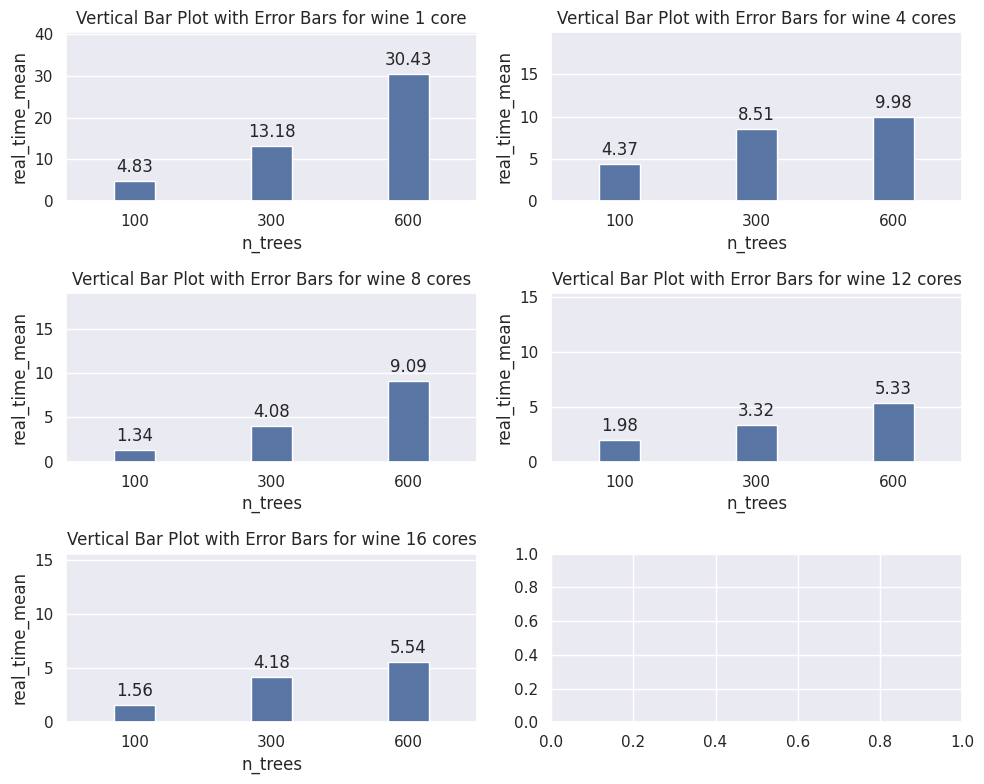

In [19]:
df_wine=df_for_plots('wine')
time_tree_plot('wine',df_wine,num_cores,n_trees)

#### Plot `real_time_single_run` vs `n_cores`

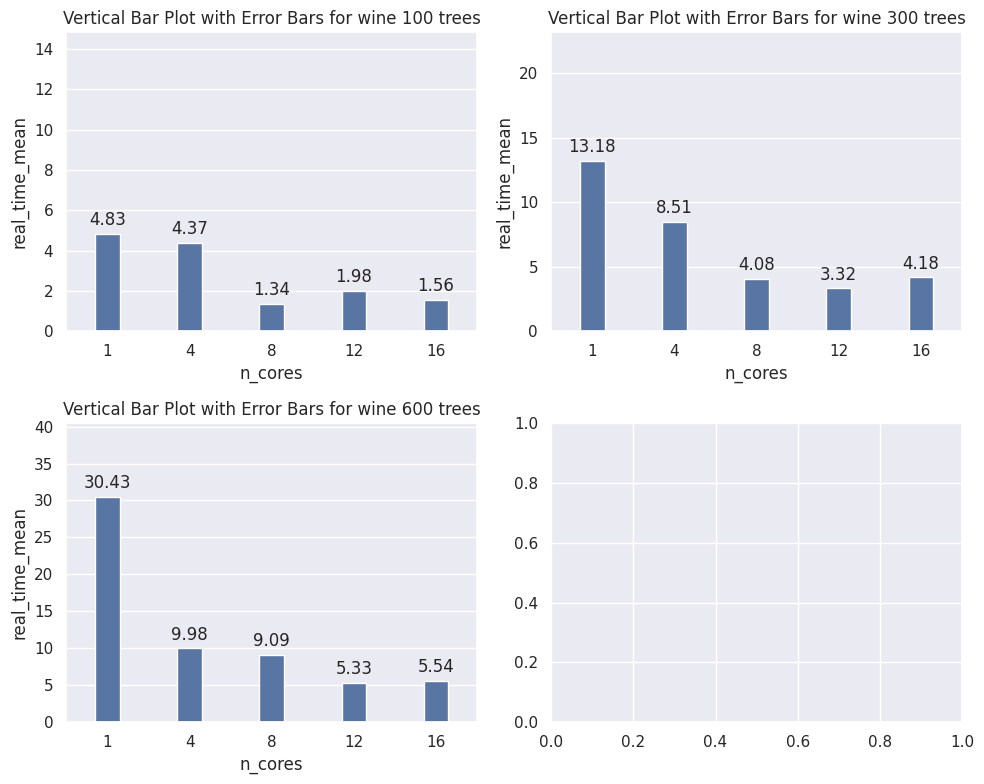

In [21]:
df_wine=df_for_plots('wine')
time_core_plot('wine',df_wine,num_cores,n_trees)

#### Plot `n_cores` vs `max_MB` 

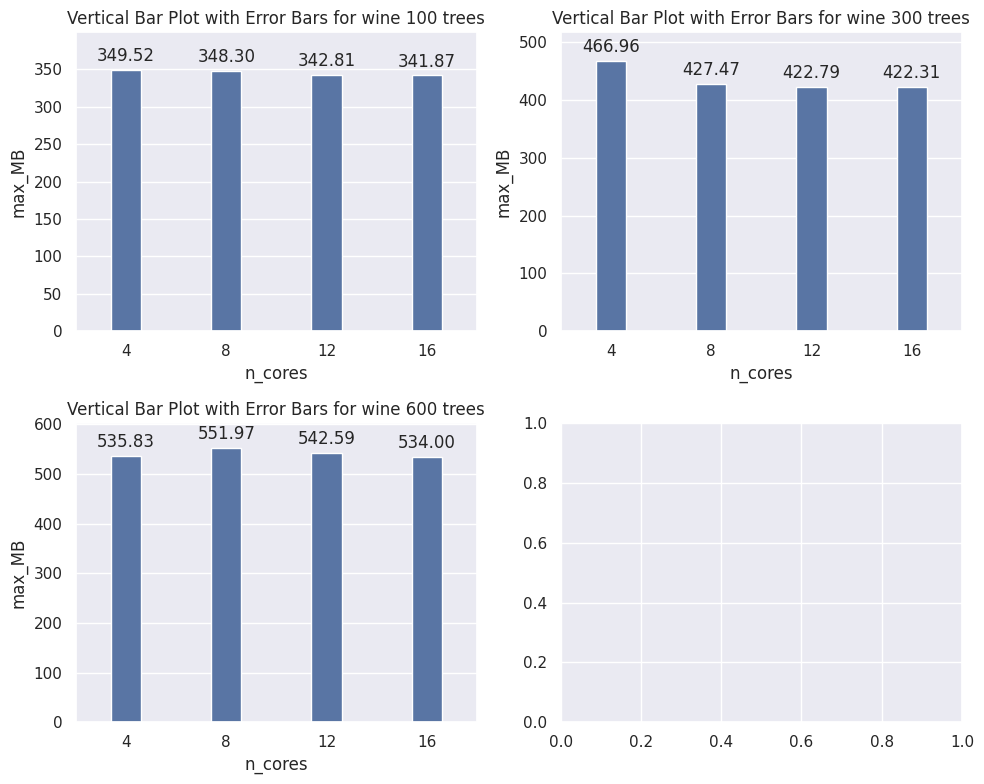

In [25]:
n_cores=[4,8,12,16]
df_wine=df_for_plots('wine')
time_mem_plot('wine',df_wine,n_cores,n_trees)

### Glass → (213,9)

In [27]:
df=df_for_plots('glass')
df

,name,n_trees,real_time,user_time,cpu_efficiency,max_MB,real_time_single_run,n_cores
7,glass,600,427.939,1317.405,76.962196,755.003392,17.11756,4
11,glass,300,578.169,602.999,26.073648,500.228096,23.12676,4
14,glass,300,558.595,555.479,99.442172,480.997376,22.34380,1
23,glass,600,57.625,50.684,87.954881,654.884864,57.62500,1
34,glass,300,248.956,698.099,70.102649,536.113152,9.95824,4
51,glass,100,199.292,192.154,96.418321,355.602432,7.97168,1
79,glass,100,178.213,247.891,8.693635,373.293056,7.12852,16
87,glass,100,89.530,249.076,23.183663,371.642368,3.58120,12
93,glass,600,364.367,1397.053,47.927399,712.134656,14.57468,8
95,glass,100,54.988,236.565,35.851004,365.338624,2.19952,12


Similar to `wine` but the efficiency increases a little

#### Plot `real_time_single_run`  vs `n_trees`

Create the dataframes for the plots

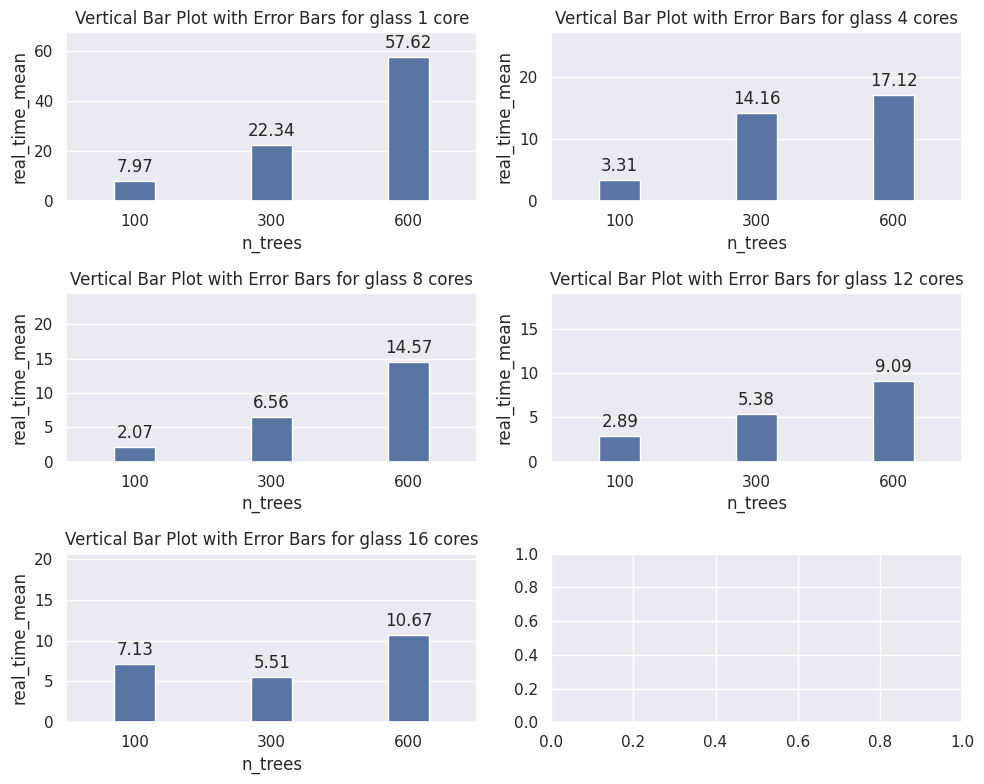

In [29]:
df=df_for_plots('glass')
time_tree_plot('glass',df,num_cores,n_trees)

#### Plot `real_time_single_run` vs `n_cores`

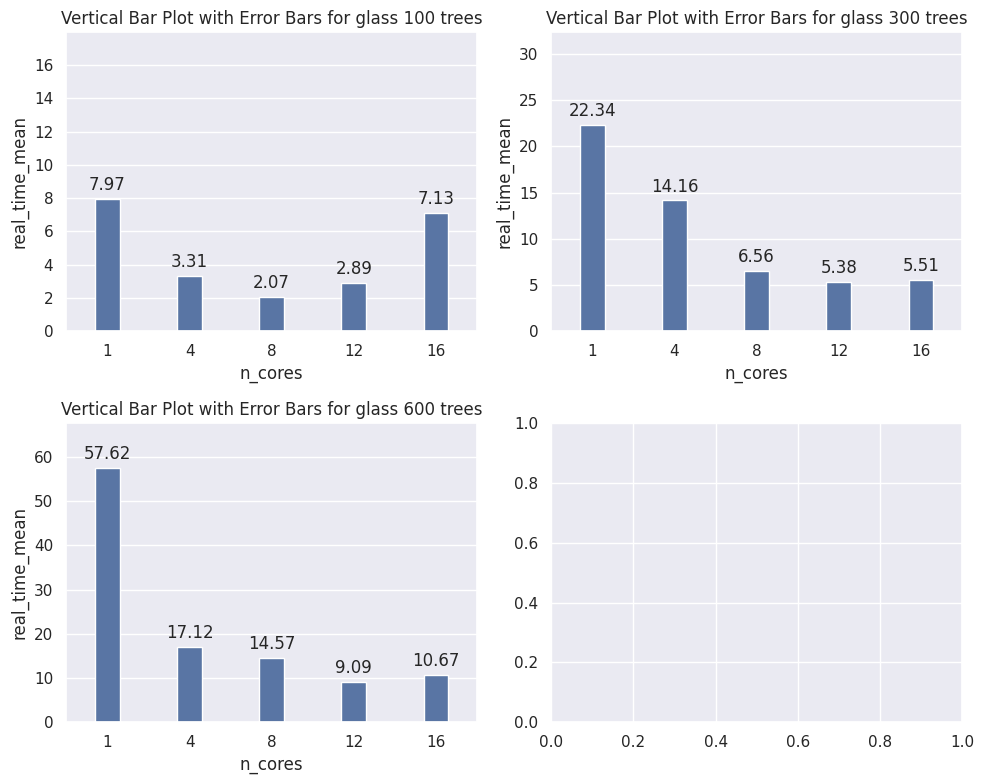

In [30]:
df=df_for_plots('glass')
time_core_plot('glass',df,num_cores,n_trees)

#### Plot `n_cores` vs `max_MB`

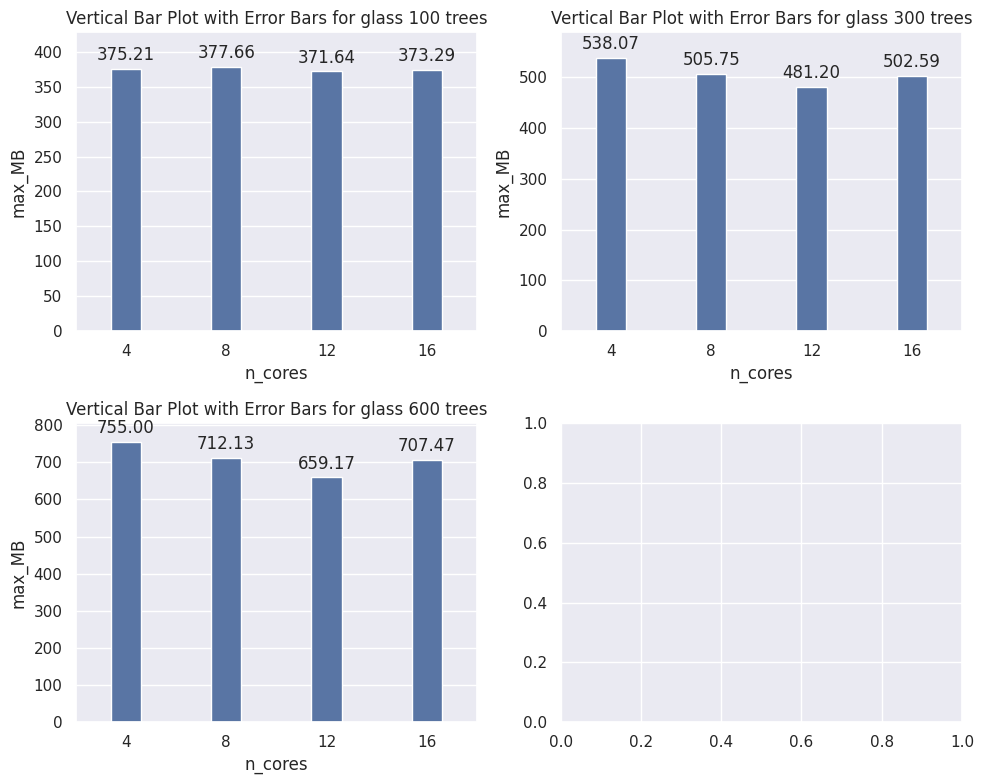

In [35]:
df=df_for_plots('glass')
time_mem_plot('glass',df,n_cores=[4,8,12,16])

### Pima → (768,8)

In [38]:
df=df_for_plots('pima')
df

,name,n_trees,real_time,user_time,cpu_efficiency,max_MB,real_time_single_run,n_cores
9,pima,100,84.015,430.135,63.996757,389.828608,3.36060,8
20,pima,300,197.092,1289.727,40.898635,516.919296,7.88368,16
39,pima,100,370.370,368.989,99.627130,377.307136,14.81480,1
53,pima,600,96.740,93.100,96.237337,732.508160,96.74000,1
68,pima,600,618.170,2581.669,52.203864,800.944128,24.72680,8
72,pima,600,759.339,2559.266,84.259665,847.175680,30.37356,4
75,pima,600,364.872,2546.671,58.163571,793.374720,14.59488,12
86,pima,100,141.434,445.083,78.673268,396.222464,5.65736,4
88,pima,300,199.027,1310.620,54.876139,511.250432,7.96108,12
115,pima,100,78.687,437.953,46.381338,378.343424,3.14748,12


The number of samples increases a lot with the respect to `wine` and `glass` so also the efficiency increased by a bit

#### Plot `real_time_single_run` vs `n_cores`

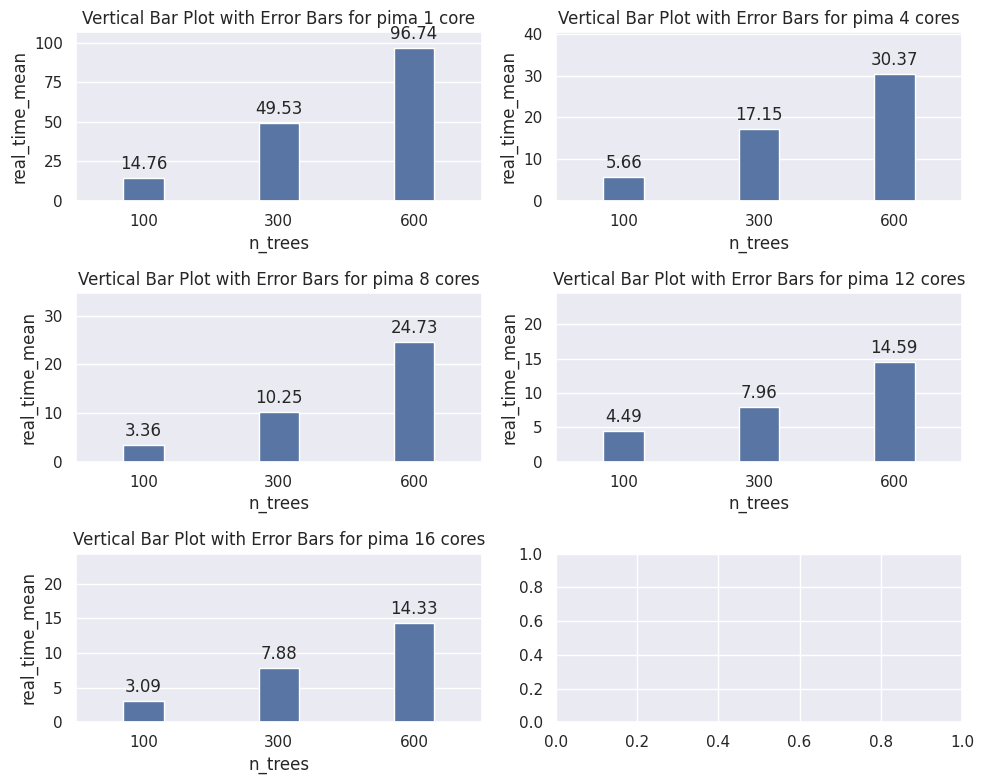

In [39]:
df=df_for_plots('pima')
time_tree_plot('pima',df)

#### Plot `real_time_single_run` vs `n_cores`

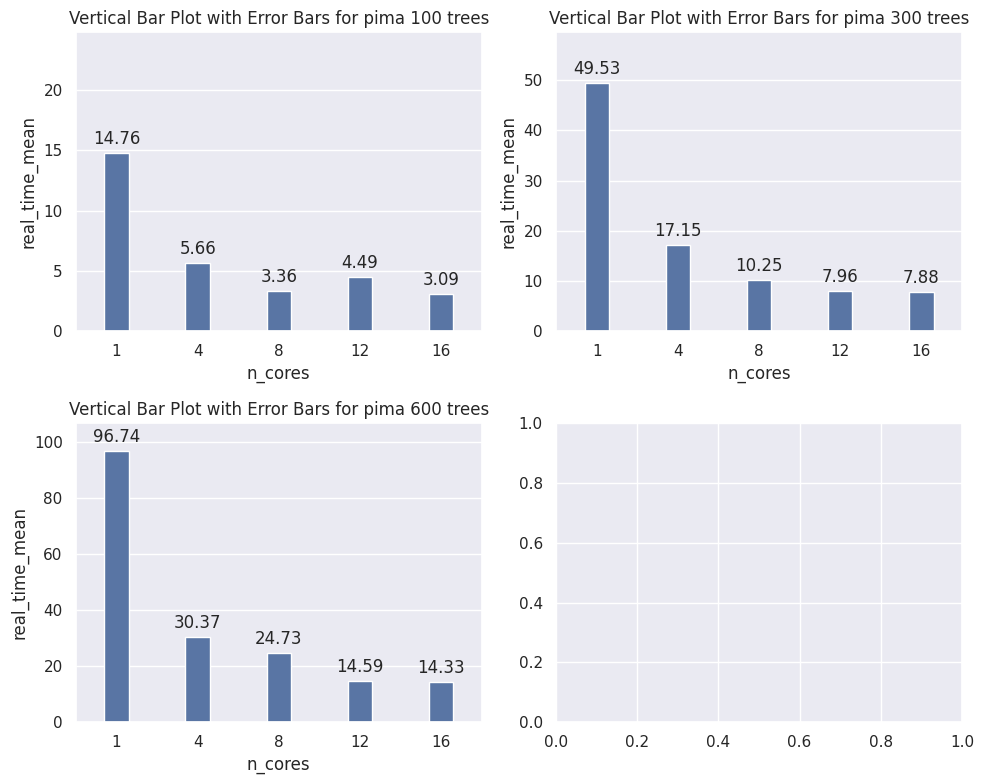

In [40]:
df=df_for_plots('pima')
time_core_plot('pima',df)

#### Plot `n_cores` vs `max_MB`

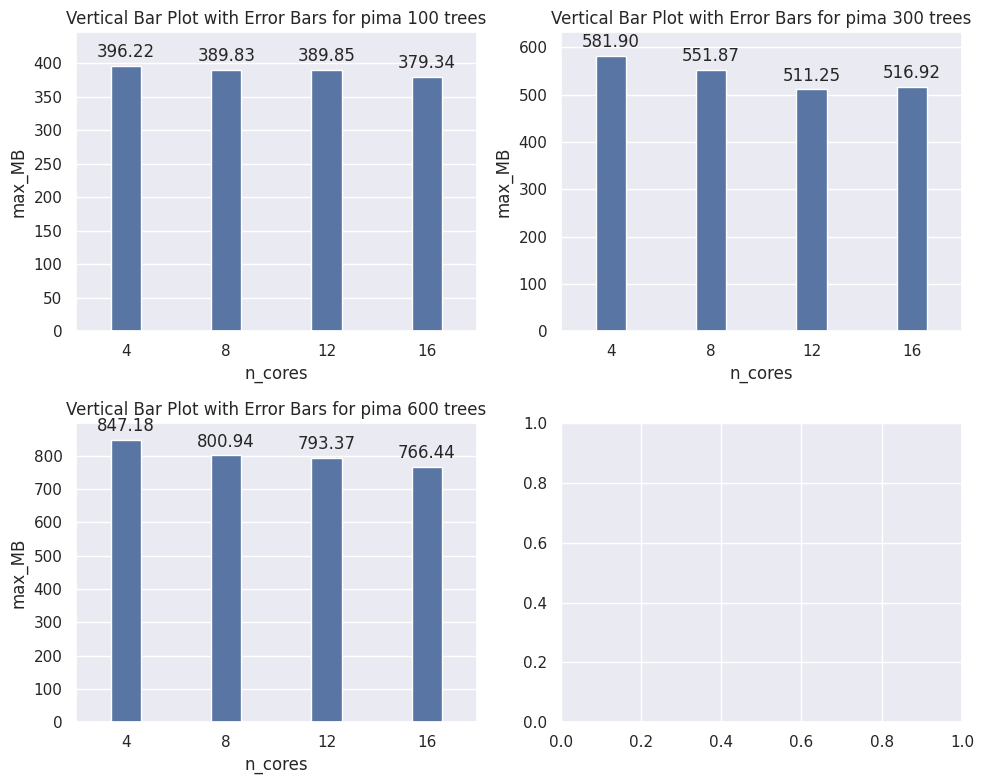

In [45]:
df=df_for_plots('pima')
time_mem_plot('pima',df,n_cores=[4,8,12,16])

### Breastw → (683,9)

In [41]:
df=df_for_plots('breastw')
df

,name,n_trees,real_time,user_time,cpu_efficiency,max_MB,real_time_single_run,n_cores
5,breastw,600,241.448,1631.697,42.237278,703.332352,9.65792,16
18,breastw,100,60.723,276.972,38.010309,371.781632,2.42892,12
21,breastw,600,59.180,56.457,95.398783,660.770816,59.18000,1
54,breastw,100,57.517,280.346,30.463385,372.936704,2.30068,16
55,breastw,300,31.827,30.659,96.330160,475.410432,31.82700,1
63,breastw,100,95.158,284.120,74.644276,387.018752,3.80632,4
65,breastw,300,185.184,826.016,55.756437,519.327744,7.40736,8
85,breastw,600,257.659,1584.070,51.232766,724.914176,10.30636,12
91,breastw,100,100.224,290.490,24.153396,378.449920,4.00896,12
92,breastw,100,241.007,239.956,99.563913,362.094592,9.64028,1


Similar to `pima`

#### Plot `real_time_single_run`  vs `n_trees`

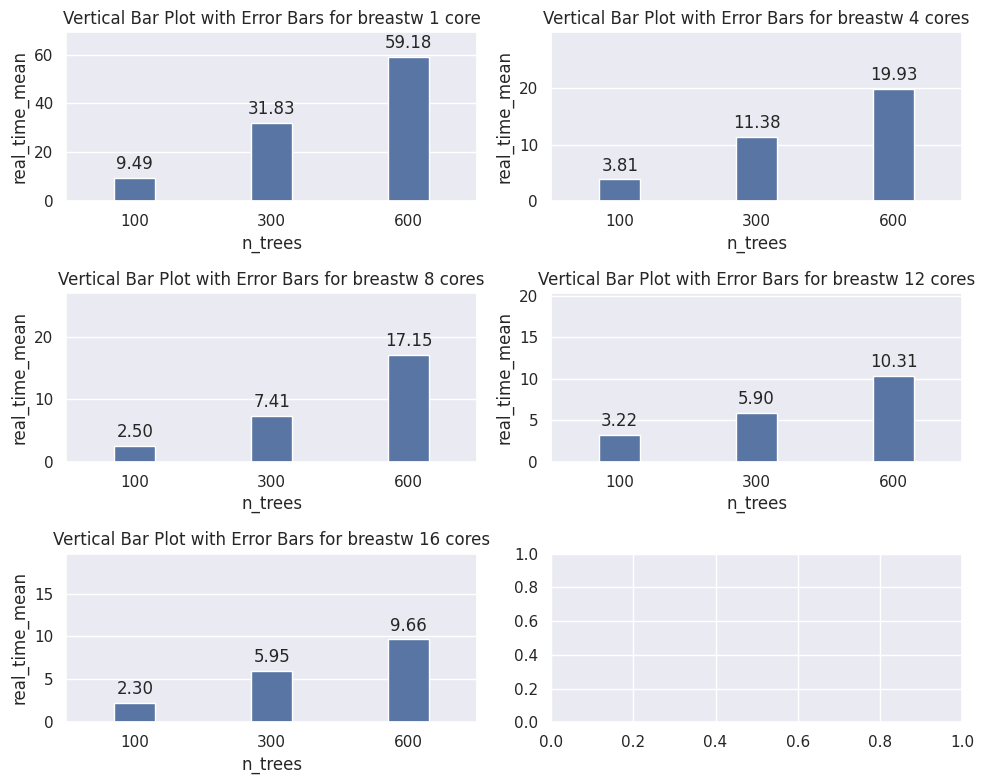

In [42]:
df=df_for_plots('breastw')
time_tree_plot('breastw',df)

#### Plot `real_time_single_run` vs `n_cores`

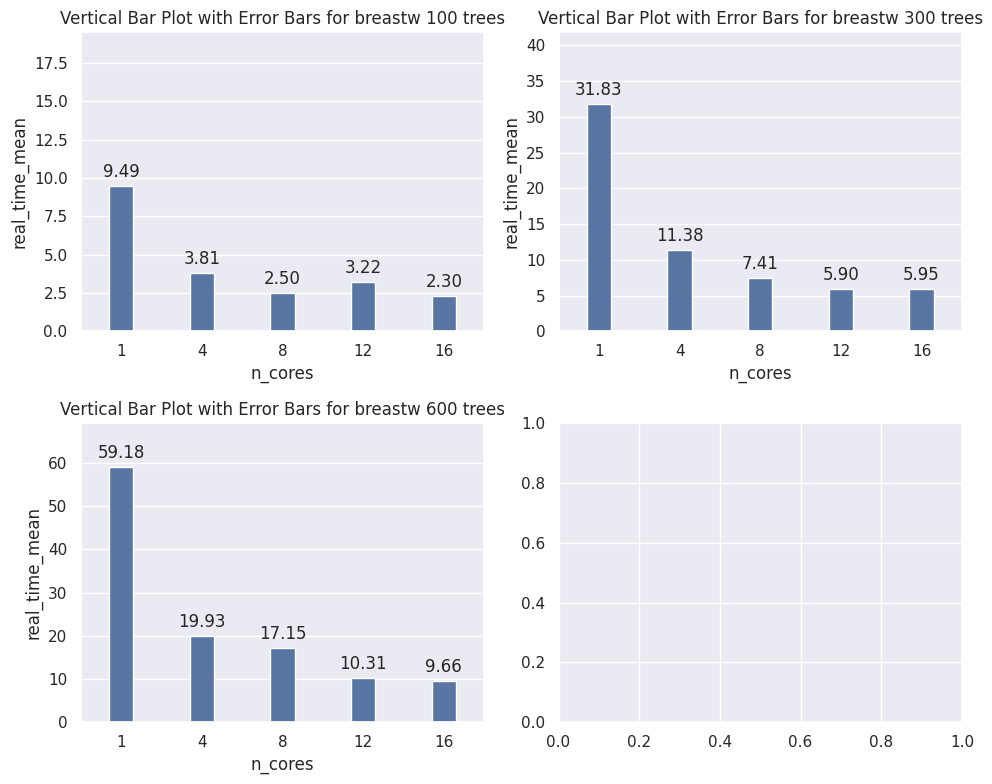

In [43]:
df=df_for_plots('breastw')
time_core_plot('breastw',df)

#### Plot `n_cores` vs `max_MB`

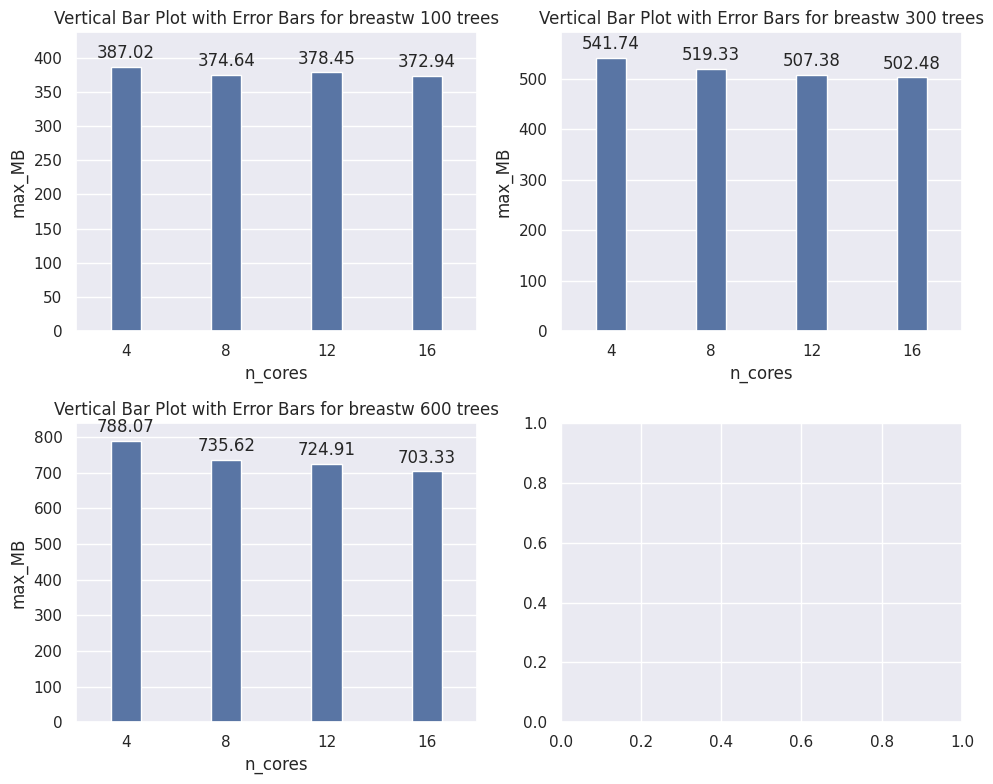

In [46]:
df=df_for_plots('breastw')
time_mem_plot('breastw',df,n_cores=[4,8,12,16])

### Ionosphere → (351,33)

In [47]:
df=df_for_plots('ionosphere')
df

,name,n_trees,real_time,user_time,cpu_efficiency,max_MB,real_time_single_run,n_cores
27,ionosphere,300,32.616,31.960,97.988717,539.226112,32.61600,1
28,ionosphere,300,162.632,871.587,44.660491,616.304640,6.50528,12
64,ionosphere,300,305.277,855.462,70.056211,655.515648,12.21108,4
67,ionosphere,100,66.373,286.681,35.993677,396.189696,2.65492,12
78,ionosphere,600,288.117,1644.778,47.572630,889.724928,11.52468,12
90,ionosphere,600,60.240,58.575,97.236056,788.721664,60.24000,1
109,ionosphere,100,124.202,292.390,14.713431,389.468160,4.96808,16
113,ionosphere,100,249.076,247.936,99.542308,394.948608,9.96304,1
118,ionosphere,100,107.189,298.937,23.240647,398.929920,4.28756,12
127,ionosphere,100,240.911,239.895,99.578267,394.592256,9.63644,1


Similar to `pima` and `breastw`. Here it seems that the number of features (that is very high in this dataset) is not affecting the execution time. It seems that the main computational effort comes when there are a lot of samples. 

#### Plot `real_time_single_run`  vs `n_trees`

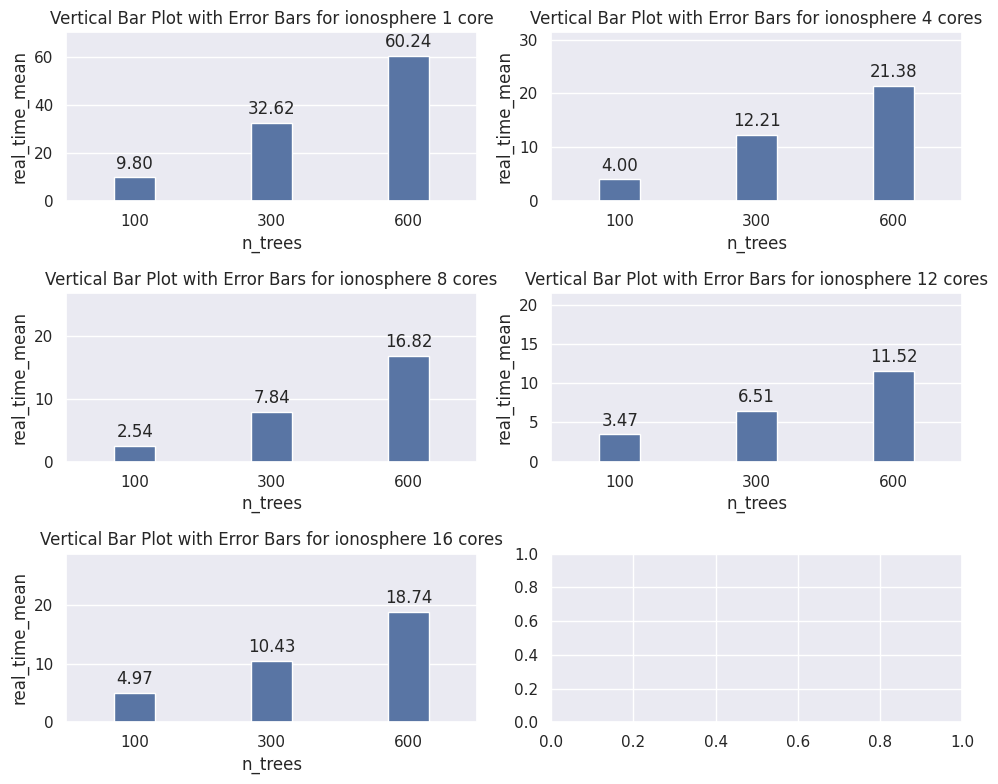

In [48]:
df=df_for_plots('ionosphere')
time_tree_plot('ionosphere',df)

#### Plot `real_time` vs `n_cores`

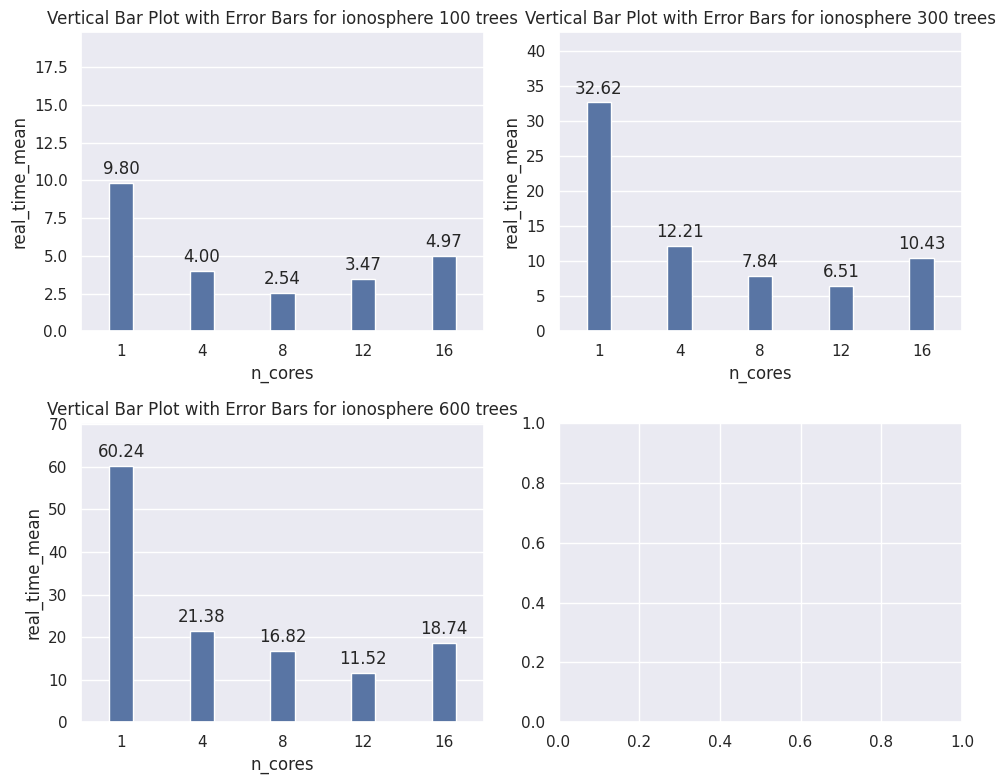

In [50]:
df=df_for_plots('ionosphere')
time_core_plot('ionosphere',df)

#### Plot `n_cores` vs `max_MB`

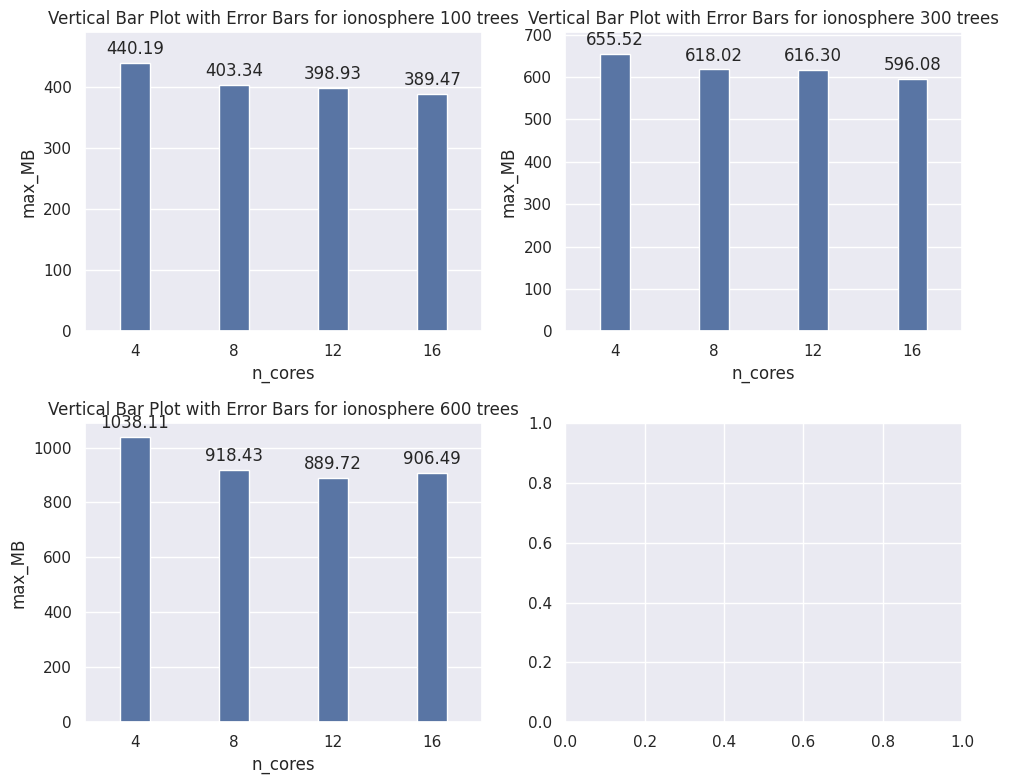

In [52]:
df=df_for_plots('ionosphere')
time_mem_plot('ionosphere',df,n_cores=[4,8,12,16])

### Cardio → (1831,21)

In [51]:
df=df_for_plots('cardio')
df

,name,n_trees,real_time,user_time,cpu_efficiency,max_MB,real_time_single_run,n_cores
1,cardio,100,716.112,712.554,99.503150,395.968512,28.64448,1
19,cardio,100,224.730,775.797,86.303231,420.519936,8.98920,4
25,cardio,300,411.823,2322.534,70.495516,626.106368,16.47292,8
33,cardio,300,308.991,2384.341,64.304489,592.920576,12.35964,12
35,cardio,300,2000.773,2177.073,27.202899,605.732864,80.03092,4
43,cardio,300,683.232,2324.940,85.071396,647.999488,27.32928,4
71,cardio,300,1908.615,2271.178,29.749033,762.687488,76.34460,4
76,cardio,600,576.953,4592.786,49.752601,891.219968,23.07812,16
84,cardio,300,2190.869,2184.656,99.716414,608.174080,87.63476,1
97,cardio,100,133.281,756.082,70.910520,393.211904,5.33124,8


##### Plot `real_time_single_run`  vs `n_trees`

We miss the serial experiments for `cardio` with 600 trees

In [ ]:
df=df_for_plots('cardio')
time_tree_plot('cardio',df)

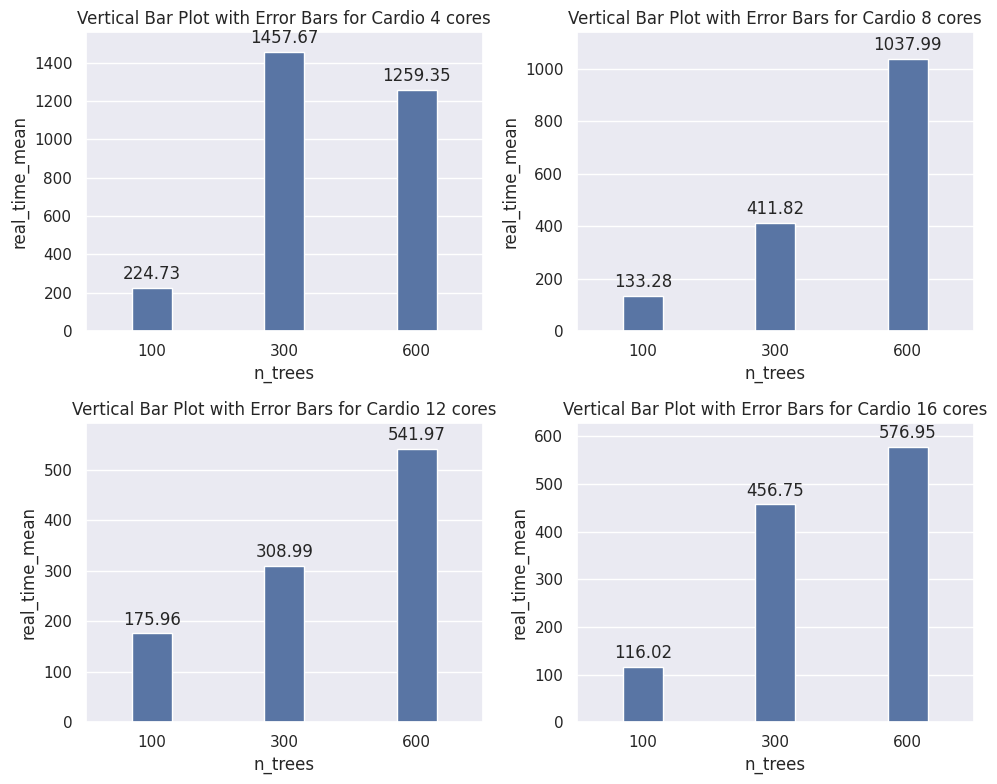

In [60]:
num_cores=[4,8,12,16]
dfs_plot=[]
for num_core in num_cores:
    df_100=df.groupby(['n_trees','n_cores']).get_group((100,num_core))
    df_300=df.groupby(['n_trees','n_cores']).get_group((300,num_core))
    df_600=df.groupby(['n_trees','n_cores']).get_group((600,num_core))
    dfs_plot.append(pd.DataFrame({
        'n_trees': [100,300,600],
        'real_time_mean':[np.mean(df_100['real_time']),np.mean(df_300['real_time']),np.mean(df_600['real_time'])]
    }))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
dfs = dfs_plot
names = ['Cardio 4 cores','Cardio 8 cores','Cardio 12 cores','Cardio 16 cores']

for i, (ax, name, df) in enumerate(zip(axes.flatten(), names, dfs)):
    if i==0 or i==1:
        barplot_subplots(ax, name, df,'n_trees','real_time_mean',ylim_off=100)
    else:
        barplot_subplots(ax, name, df,'n_trees','real_time_mean')

plt.tight_layout()
plt.show()

#### Plot `real_time_single_run` vs `n_cores`

In [ ]:
df=df_for_plots('cardio')
time_core_plot('cardio',df)

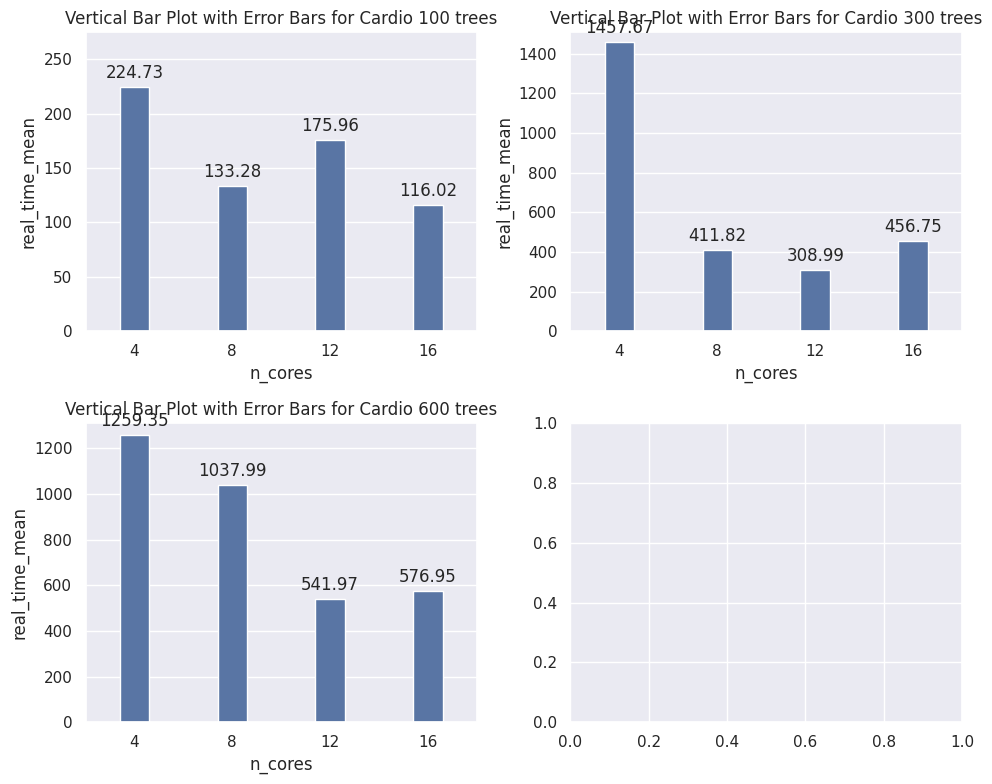

In [106]:
num_trees=[100,300,600]
dfs_plot=[]
for num_tree in num_trees:
    df_4=df.groupby(['n_cores','n_trees']).get_group((4,num_tree))
    df_8=df.groupby(['n_cores','n_trees']).get_group((8,num_tree))
    df_12=df.groupby(['n_cores','n_trees']).get_group((12,num_tree))
    df_16=df.groupby(['n_cores','n_trees']).get_group((16,num_tree))
    dfs_plot.append(pd.DataFrame({
        'n_cores': [4,8,12,16],
        'real_time_mean':[np.mean(df_4['real_time']),np.mean(df_8['real_time']),np.mean(df_12['real_time']),np.mean(df_16['real_time'])]
    }))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
dfs = dfs_plot
names = ['Cardio 100 trees','Cardio 300 trees','Cardio 600 trees']

for i, (ax, name, df) in enumerate(zip(axes.flatten(), names, dfs)):
    barplot_subplots(ax, name, df,'n_cores','real_time_mean')

plt.tight_layout()
plt.show()

#### Plot `n_cores` vs `max_MB`

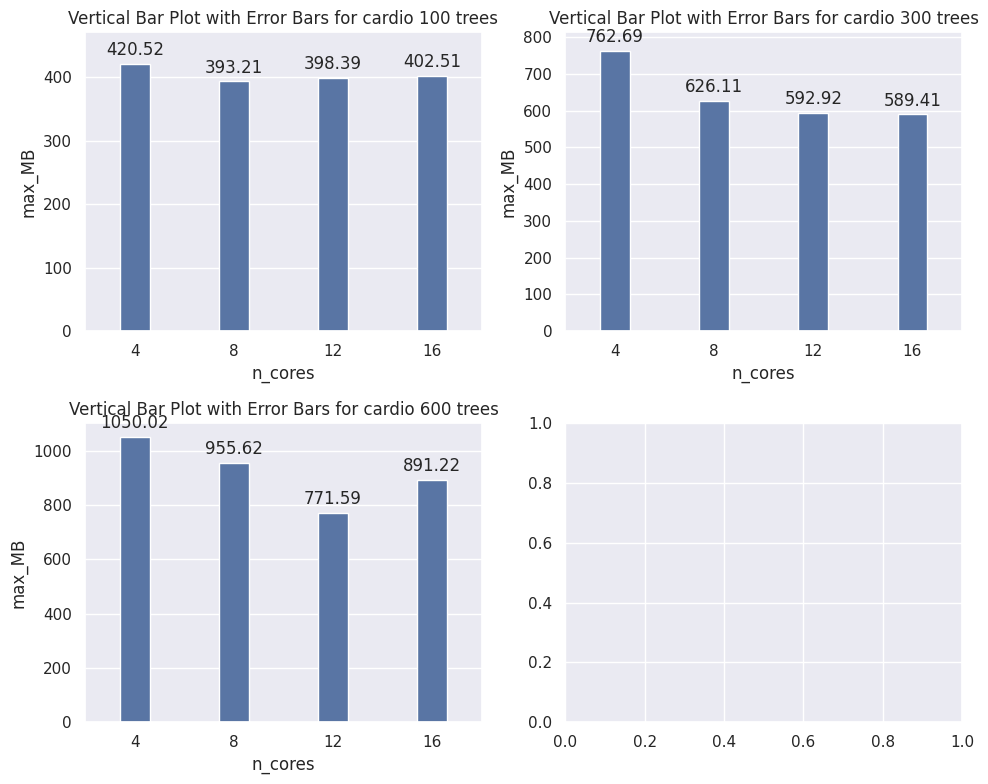

In [55]:
df=df_for_plots('cardio')
time_mem_plot('cardio',df,n_cores=[4,8,12,16])

### Annthyroid → (7200,6)

In [56]:
df=df_for_plots('annthyroid')
df

,name,n_trees,real_time,user_time,cpu_efficiency,max_MB,real_time_single_run,n_cores
2,annthyroid,100,654.080,2435.787,31.033245,382.894080,26.16320,12
6,annthyroid,600,1314.930,13741.861,87.088673,770.400256,52.59720,12
31,annthyroid,100,2311.464,2309.838,99.929655,396.709888,92.45856,1
36,annthyroid,100,287.919,2342.936,67.812359,381.181952,11.51676,12
41,annthyroid,300,310.624,309.906,99.768852,568.590336,310.62400,1
66,annthyroid,100,632.782,2365.817,93.468880,391.864320,25.31128,4
82,annthyroid,300,1862.890,6965.303,93.474427,615.780352,74.51560,4
83,annthyroid,600,1178.606,14062.948,74.574052,768.081920,47.14424,16
100,annthyroid,600,3554.743,13562.688,95.384448,836.046848,142.18972,4
121,annthyroid,100,376.111,2338.203,77.709872,382.488576,15.04444,8


#### Plot `real_time_single_run` vs `n_trees`

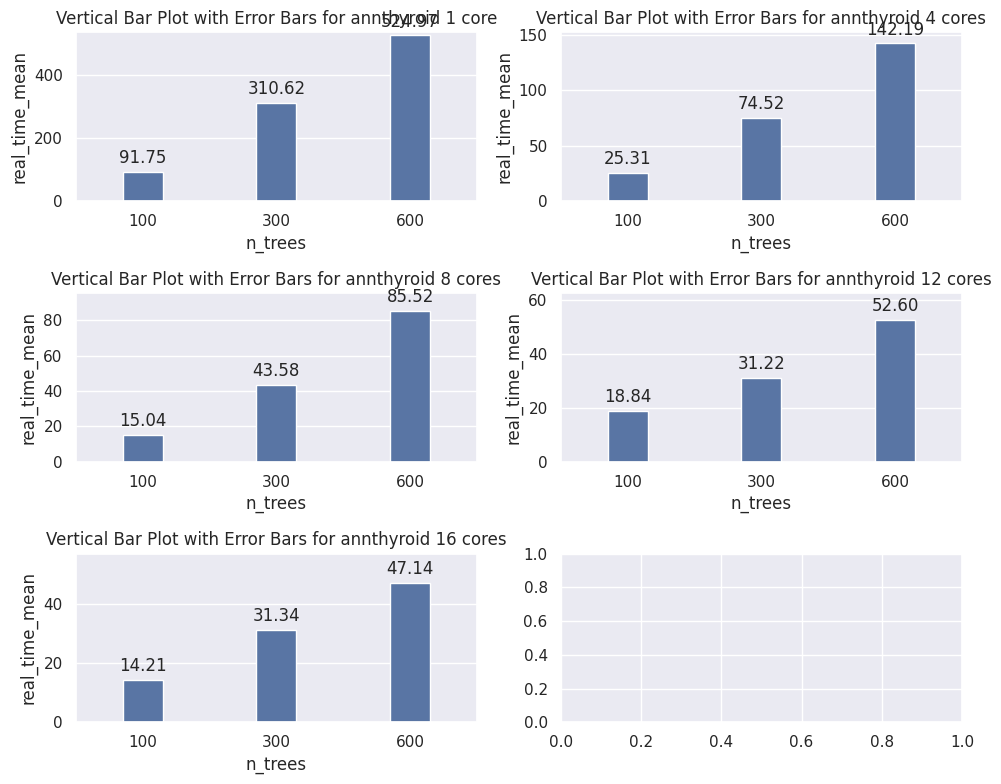

In [57]:
df=df_for_plots('annthyroid')
time_tree_plot('annthyroid',df)

The number of samples increased a lot here and so also the efficiency which is higher than 90% 

#### Plot `real_time` vs `n_cores`

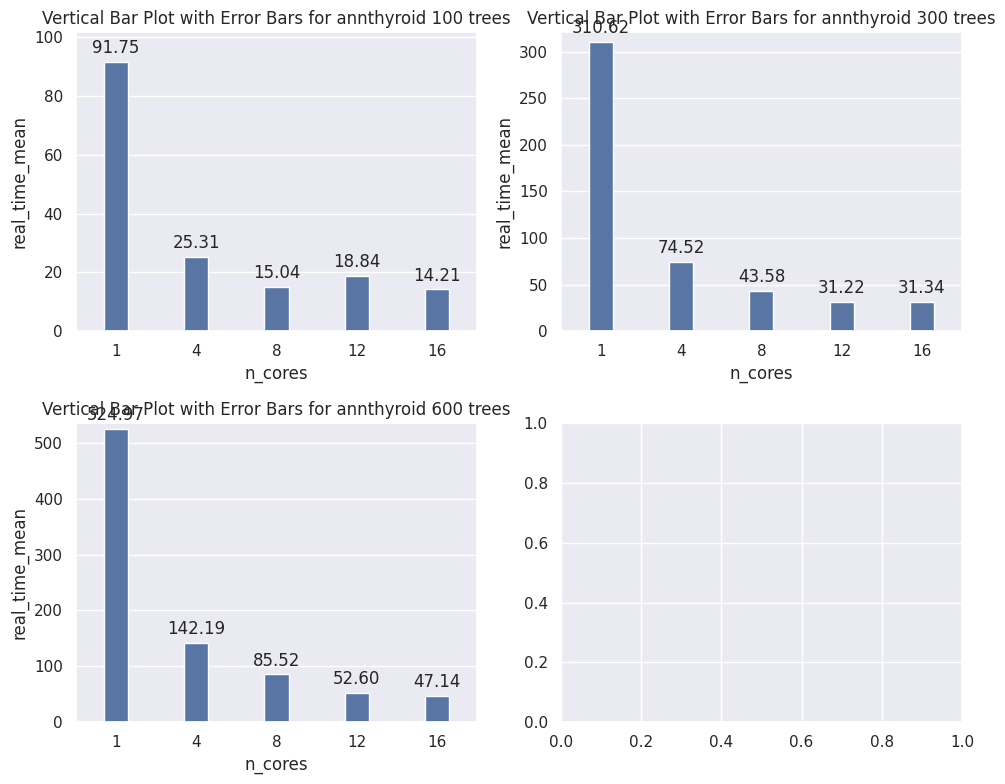

In [58]:
df=df_for_plots('annthyroid')
time_core_plot('annthyroid',df)

#### Plot `n_cores` vs `max_MB`

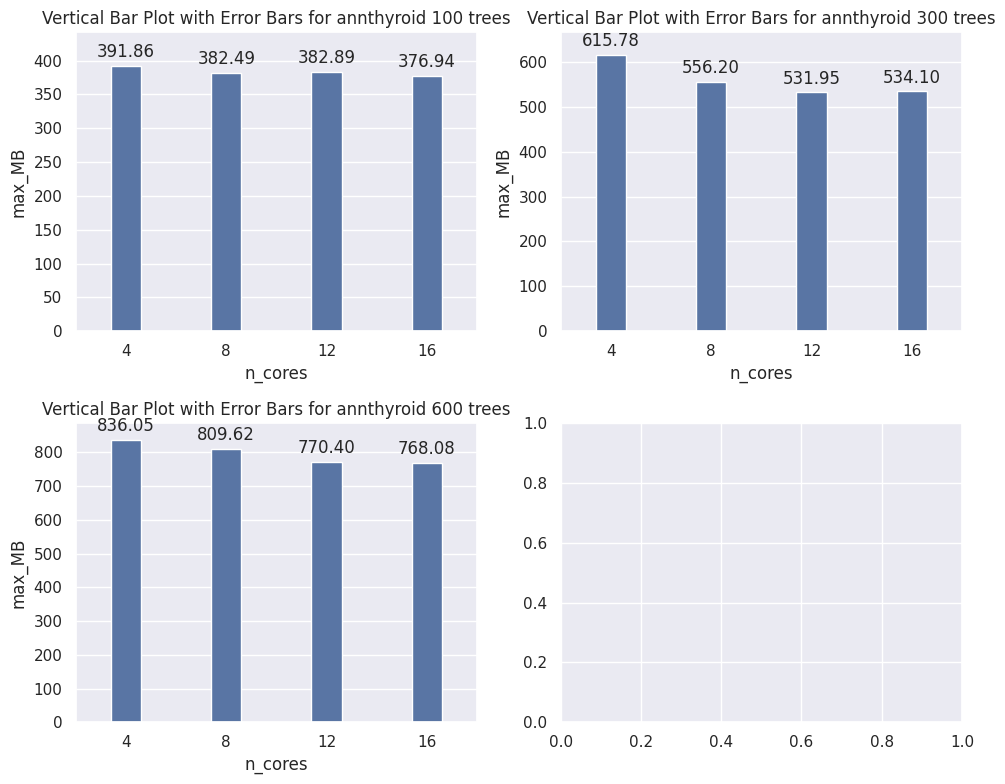

In [59]:
df=df_for_plots('annthyroid')
time_mem_plot('annthyroid',df,n_cores=[4,8,12,16])

### Pendigits → (6870,16)

In [60]:
df=df_for_plots('pendigits')
df

,name,n_trees,real_time,user_time,cpu_efficiency,max_MB,real_time_single_run,n_cores
3,pendigits,50,1269.986,1227.799,6.042385,349.224960,50.79944,16
8,pendigits,600,2298.918,14171.621,77.055929,926.969856,91.95672,8
12,pendigits,300,2018.600,7050.350,87.317324,653.594624,80.74400,4
24,pendigits,300,767.125,7137.036,58.147597,551.481344,30.68500,16
26,pendigits,50,1194.198,1160.801,6.075212,350.777344,47.76792,16
30,pendigits,50,1291.974,1248.306,6.038753,353.124352,51.67896,16
32,pendigits,600,1313.127,13581.187,86.188585,786.714624,52.52508,12
40,pendigits,100,299.247,2388.455,66.512920,394.551296,11.96988,12
47,pendigits,100,315.567,2353.140,46.605396,395.579392,12.62268,16
52,pendigits,300,796.845,7301.124,76.354498,584.949760,31.87380,12


Similar to `annthyroid`

#### Plot `real_time_single_run`  vs `n_trees`

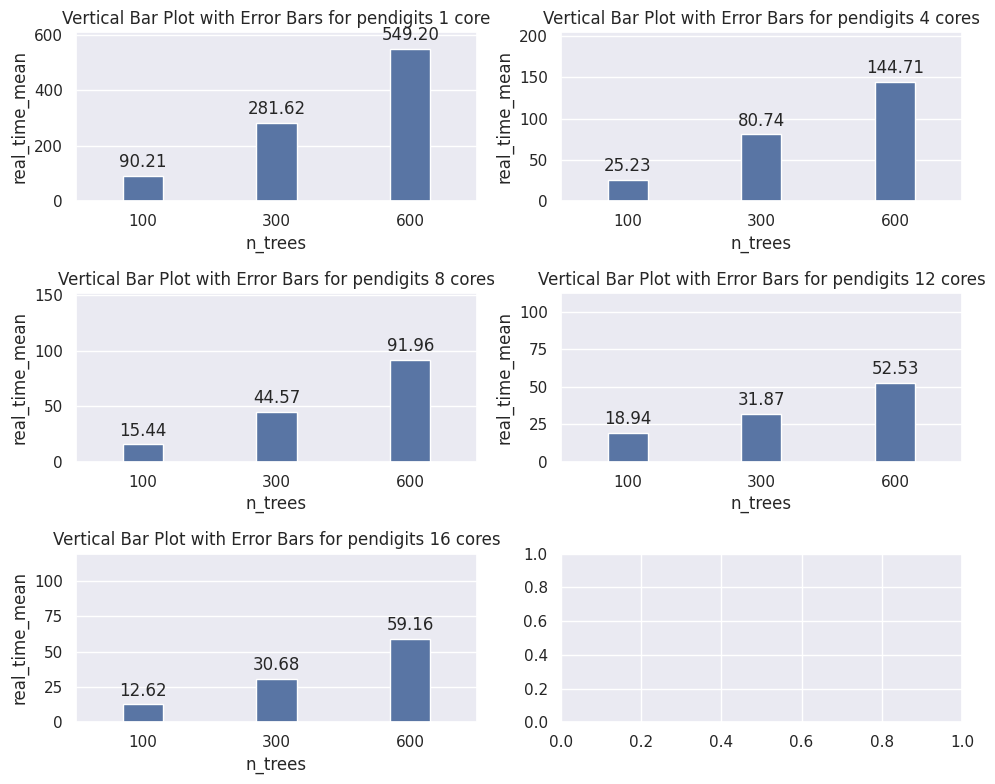

In [66]:
df=df_for_plots('pendigits')
time_tree_plot('pendigits',df,ylim_off=60)

#### Plot `real_time` vs `n_cores`

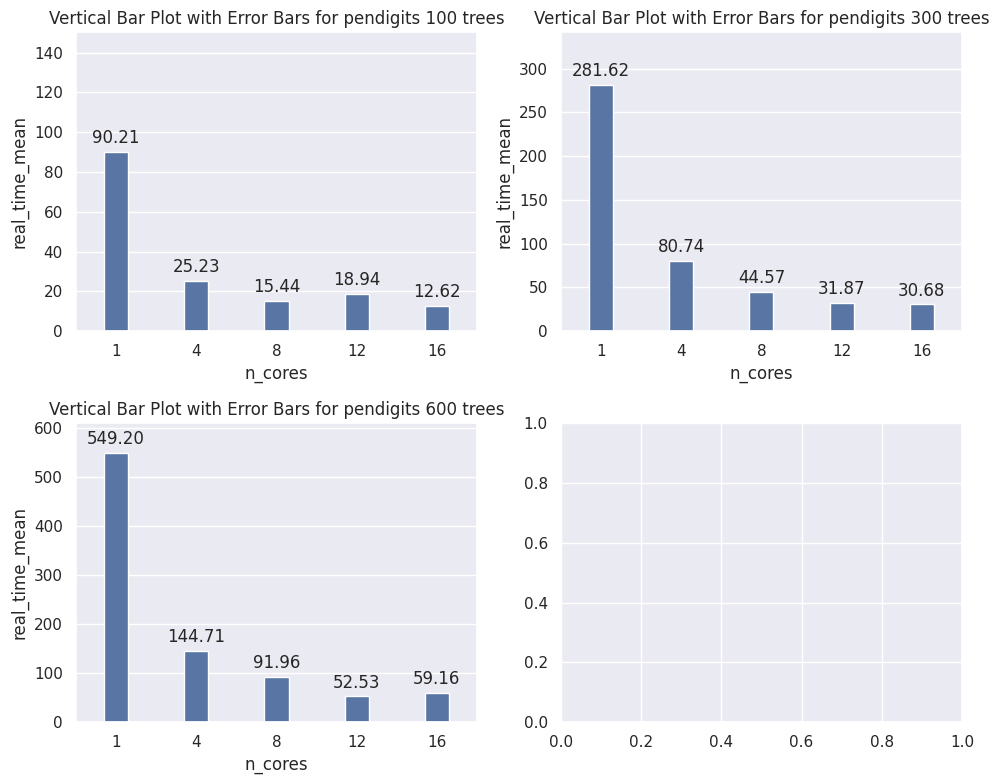

In [68]:
df=df_for_plots('pendigits')
time_core_plot('pendigits',df,ylim_off=60)

#### Plot `n_cores` vs `max_MB`

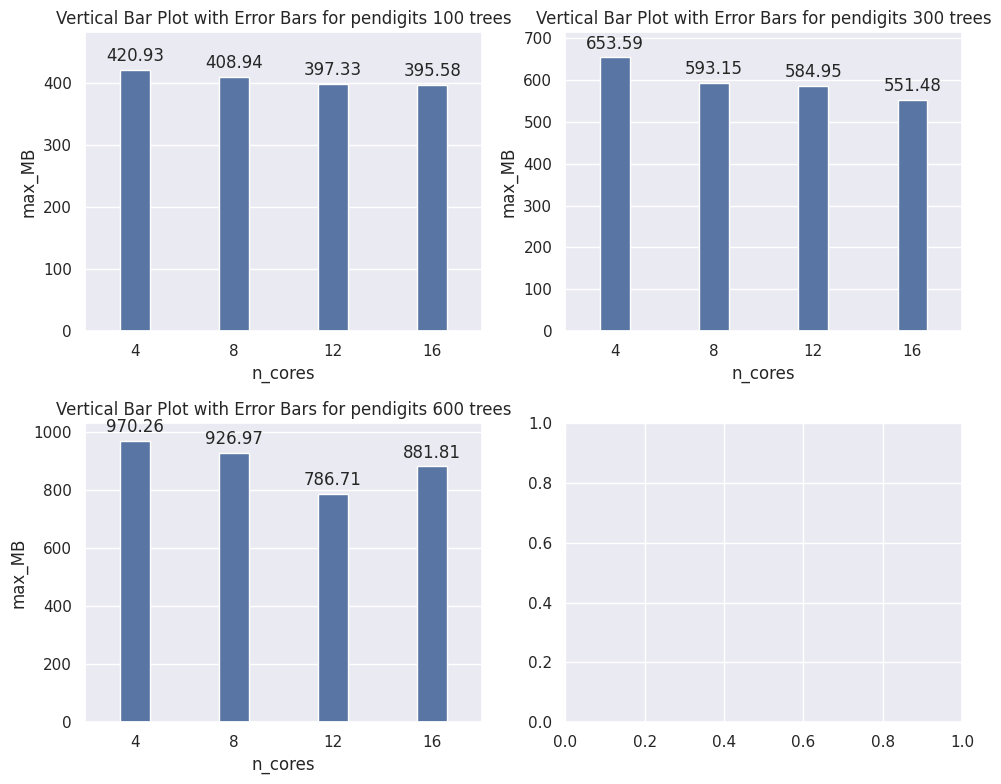

In [70]:
df=df_for_plots('pendigits')
time_mem_plot('pendigits',df,n_cores=[4,8,12,16],ylim_off=60)

### Diabetes → (85916,4)

In [71]:
df=df_for_plots('diabetes')
df

,name,n_trees,real_time,user_time,cpu_efficiency,max_MB,real_time_single_run,n_cores
0,diabetes,600,13552.625,153164.436,94.178825,773.652480,542.10500,12
4,diabetes,300,2693.030,2691.144,99.929967,766.365696,2693.03000,1
15,diabetes,100,24825.700,24810.749,99.939776,497.770496,993.02800,1
29,diabetes,600,11169.609,153305.581,85.782759,760.442880,446.78436,16
37,diabetes,600,20502.224,153337.181,93.488139,790.196224,820.08896,8
48,diabetes,300,7332.245,75617.603,64.456387,592.334848,293.28980,16
98,diabetes,300,19753.084,75955.915,96.131717,650.469376,790.12336,4
116,diabetes,600,5616.052,5612.381,99.934634,1189.568512,5616.05200,1
134,diabetes,300,11171.858,77912.916,87.175423,570.601472,446.87432,8
144,diabetes,100,24004.258,23985.255,99.920835,498.876416,960.17032,1


Here we increased of one order of magnitude so the efficiency is higher than 80% both with 4 and 8 cores

#### Plot `real_time_single_run`  vs `n_trees`

We have to wait for the execution with 600 trees and 16 cores

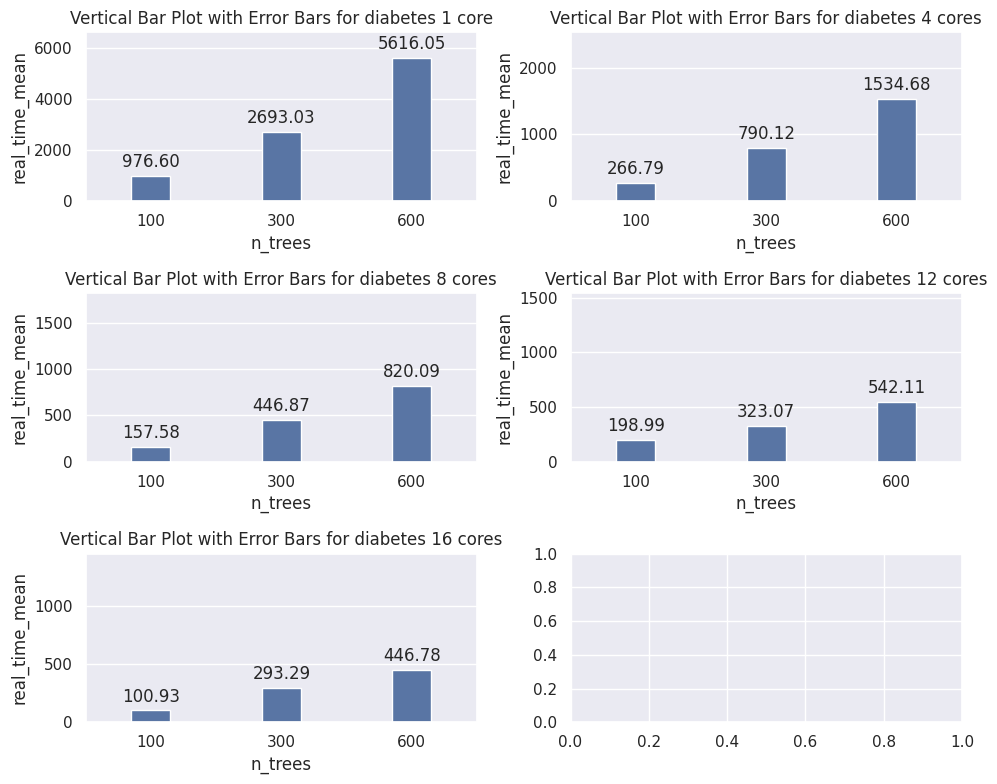

In [76]:
df=df_for_plots('diabetes')
time_tree_plot('diabetes',df,ylim_off=1000)

#### Plot `real_time_single_tree` vs `n_cores`


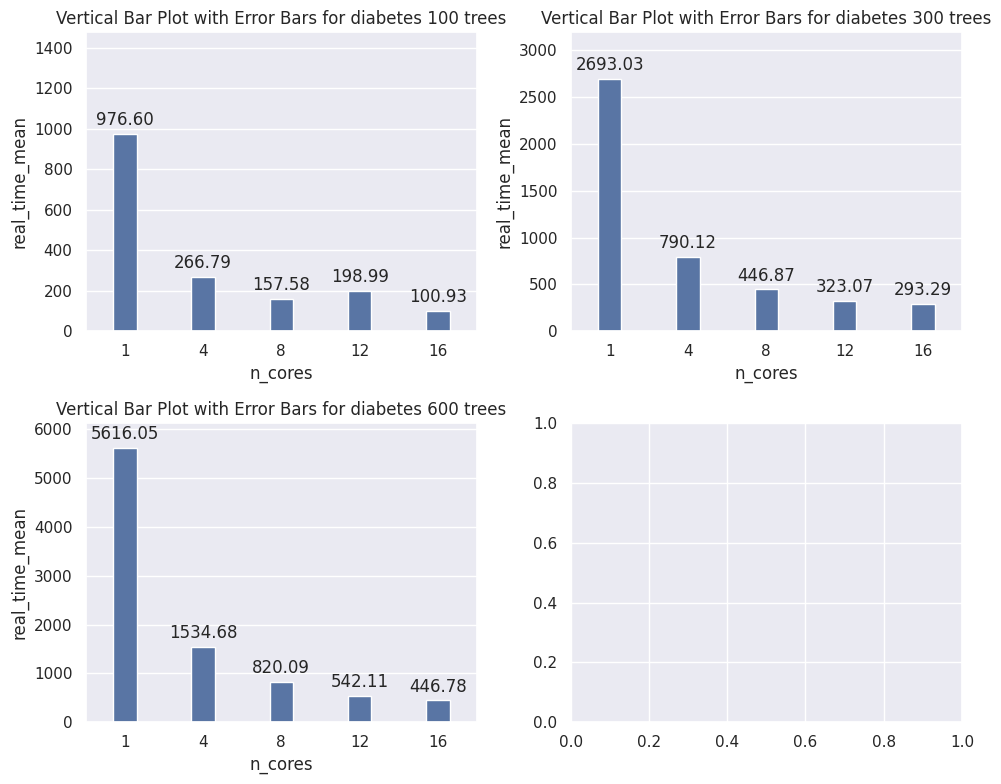

In [79]:
df=df_for_plots('diabetes')
time_core_plot('diabetes',df,ylim_off=500)

#### Plot `n_cores` vs `max_MB`

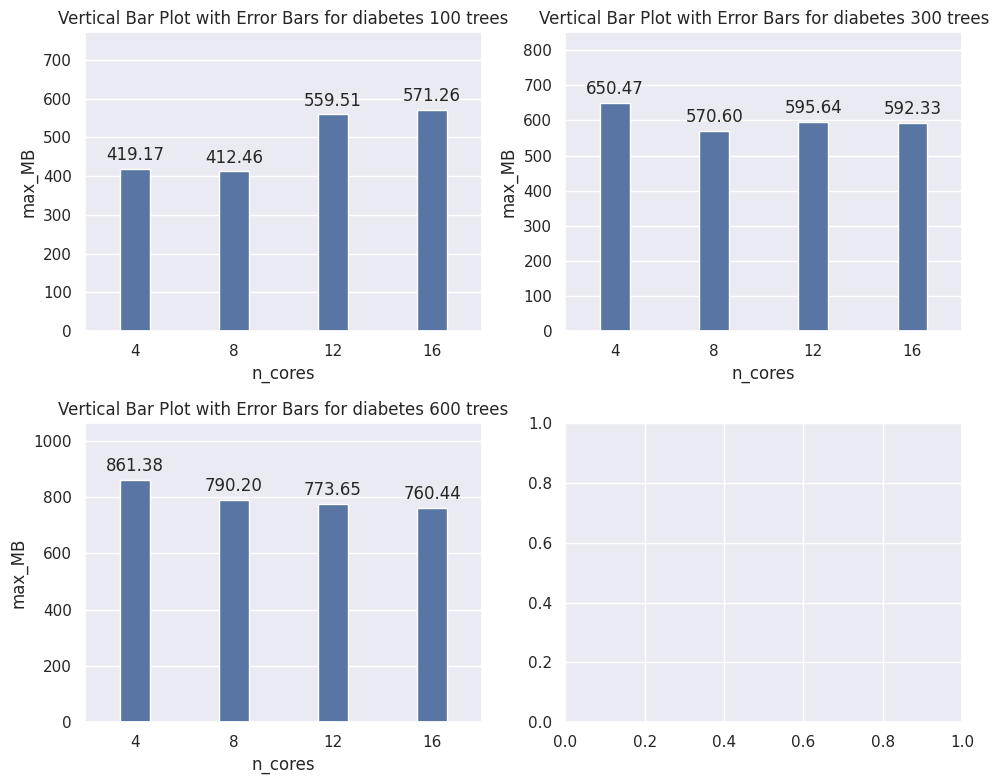

In [82]:
df=df_for_plots('diabetes')
time_mem_plot('diabetes',df,n_cores=[4,8,12,16],ylim_off=200)

### Shuttle → (49097,9)

In [83]:
df=df_for_plots('shuttle')
df

,name,n_trees,real_time,user_time,cpu_efficiency,max_MB,real_time_single_run,n_cores
10,shuttle,100,1723.144,14860.664,71.867973,521.879552,68.92576,12
22,shuttle,100,3897.614,15028.492,32.131820,519.294976,155.90456,12
45,shuttle,300,4713.842,46049.017,81.407440,625.942528,188.55368,12
74,shuttle,100,1985.164,14879.219,46.845056,536.670208,79.40656,16
81,shuttle,600,6822.832,89914.496,82.365446,866.004992,272.91328,16
102,shuttle,300,11103.381,43164.838,97.188501,651.337728,444.13524,4
105,shuttle,600,11983.490,89454.695,93.310353,836.804608,479.33960,8
106,shuttle,100,160.425,585.802,91.289076,383.123456,160.42500,4
110,shuttle,600,3683.155,3674.240,99.757952,980.914176,3683.15500,1
111,shuttle,100,14240.975,14226.500,99.898357,463.888384,569.63900,1


#### Plots `real_time_single_run`  vs `n_trees`


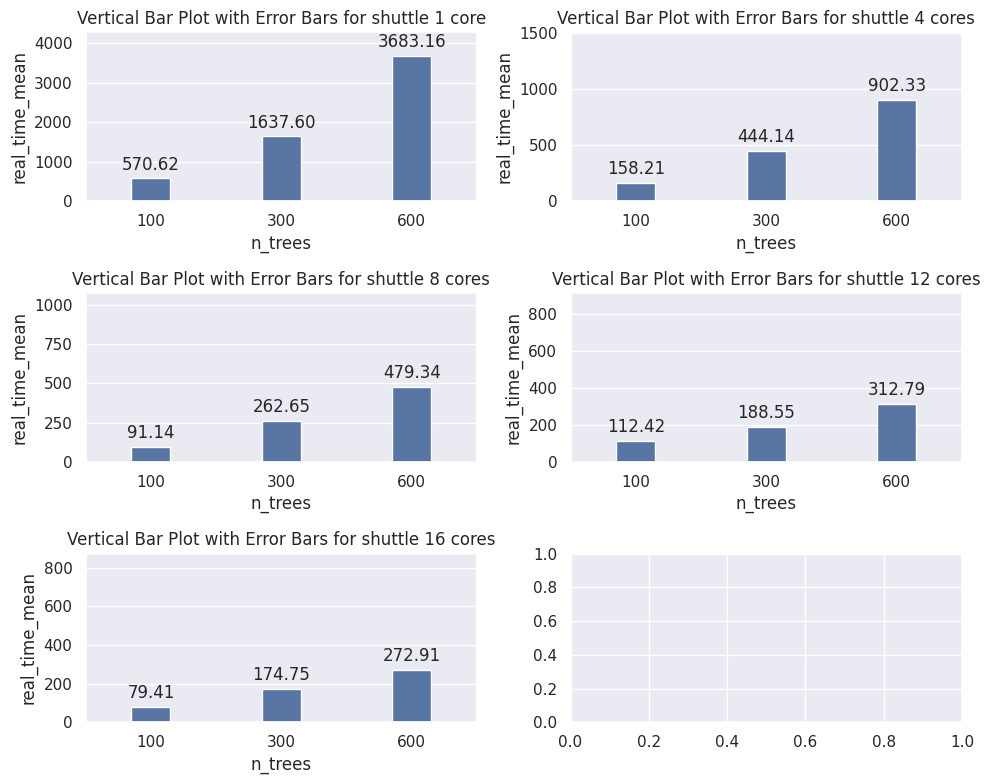

In [86]:
df=df_for_plots('shuttle')
time_tree_plot('shuttle',df,ylim_off=600)

#### Plot `real_time_single_run` vs `n_cores`


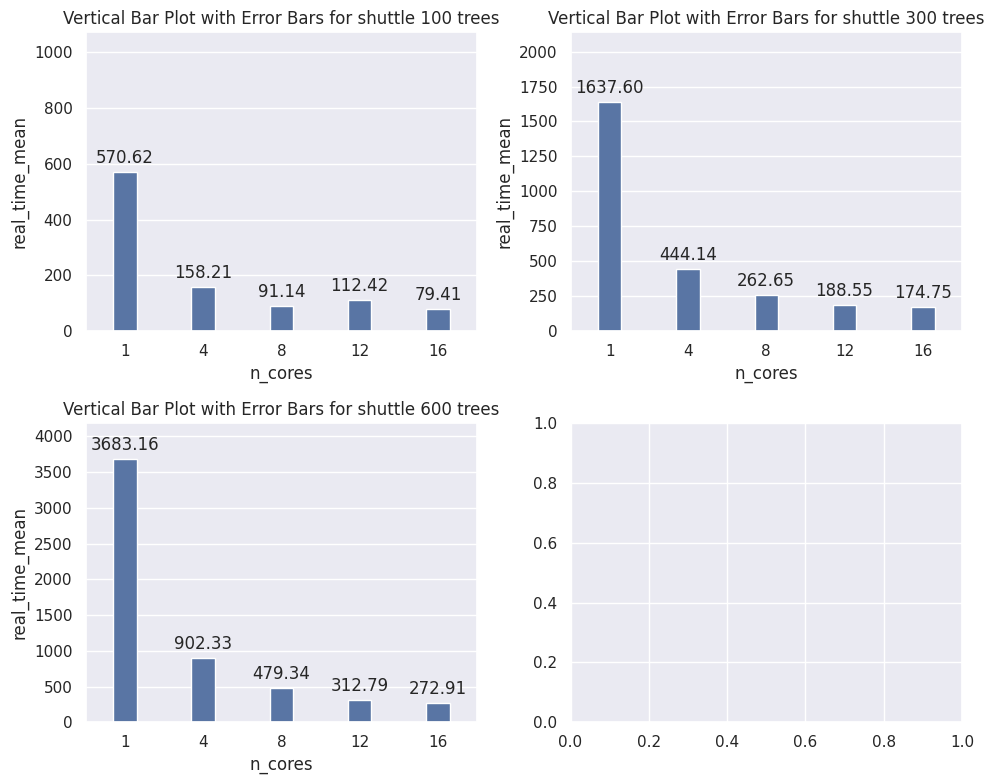

In [89]:
df=df_for_plots('shuttle')
time_core_plot('shuttle',df,ylim_off=500)

Similar to `shuttle`

#### Plot `n_cores` vs `max_MB`

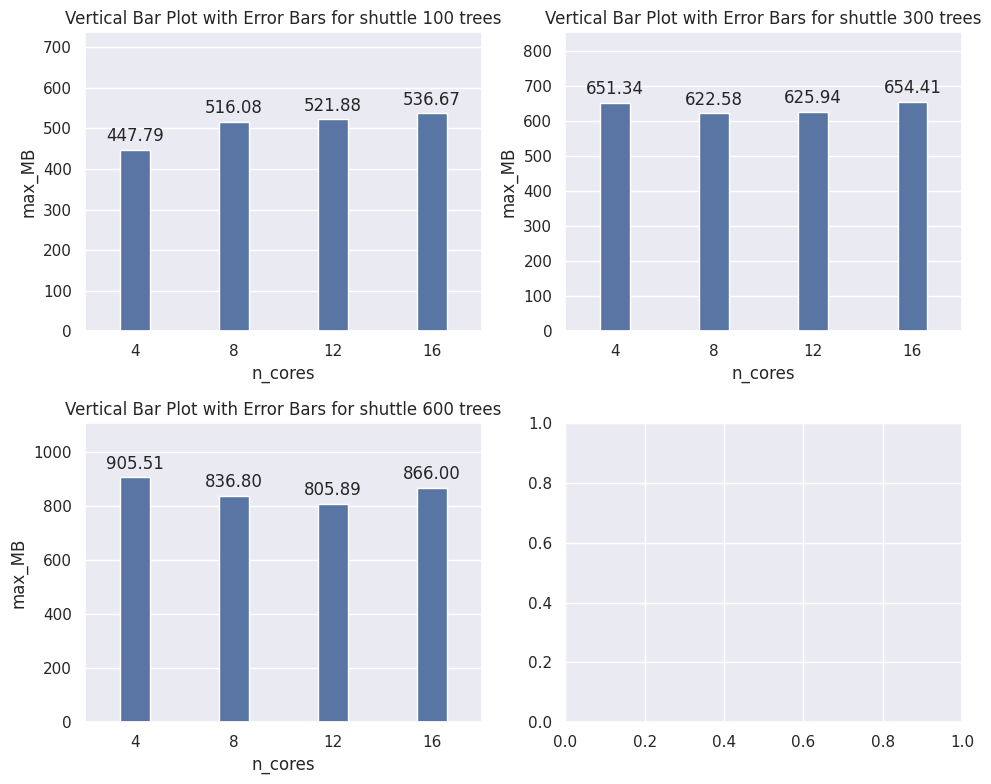

In [90]:
df=df_for_plots('shuttle')
time_mem_plot('shuttle',df,n_cores=[4,8,12,16],ylim_off=200)

### Moodify → (276260,11)

In [91]:
df=df_for_plots('moodify')
df

,name,n_trees,real_time,user_time,cpu_efficiency,max_MB,real_time_single_run,n_cores
16,moodify,100,21138.158,81291.575,96.143163,615.006208,845.52632,4
38,moodify,600,19818.368,19797.224,99.893311,2249.596928,19818.36800,1
49,moodify,600,5514.990,20861.997,94.569514,765.743104,5514.99000,4
50,moodify,100,7867.514,81780.135,64.966627,605.736960,314.70056,16
56,moodify,100,12237.144,81111.811,82.854107,606.105600,489.48576,8
58,moodify,600,42597.168,483784.903,94.643401,1017.737216,1703.88672,12
60,moodify,100,3311.271,3306.600,99.858936,823.844864,3311.27100,1
62,moodify,300,60871.080,236871.421,97.284055,701.804544,2434.84320,4
89,moodify,300,24627.632,256101.176,86.657802,704.532480,985.10528,12
122,moodify,100,776.430,3055.941,98.397183,584.642560,776.43000,4


#### Plot `real_time_single_run`  vs `n_trees`

We miss the serial experiment with 300 trees

In [ ]:
df=df_for_plots('moodify')
time_tree_plot('moodify',df)

In [ ]:
num_cores=[4,8,12,16]
dfs_plot=[]
for num_core in num_cores:
    df_100=df.groupby(['n_trees','n_cores']).get_group((100,num_core))
    df_300=df.groupby(['n_trees','n_cores']).get_group((300,num_core))
    df_600=df.groupby(['n_trees','n_cores']).get_group((600,num_core))
    dfs_plot.append(pd.DataFrame({
        'n_trees': [100,300,600],
        'real_time_mean':[np.mean(df_100['real_time']),np.mean(df_300['real_time']),np.mean(df_600['real_time'])]
    }))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
dfs = dfs_plot
names = ['Moodify 4 cores','Moodify 8 cores','Moodify 12 cores','Moodify 16 cores']

for i, (ax, name, df) in enumerate(zip(axes.flatten(), names, dfs)):
    barplot_subplots(ax, name, df,'n_trees','real_time_mean',ylim_off=500)

plt.tight_layout()
plt.show()

`Moodify` is a very big dataset and it takes a while to work with it so for the moment we were able to produce just the results with the parallel algorithm which obviously have a very high CPU Efficiency

#### Plot `real_time_single_run` vs `n_cores`

In [ ]:
df=df_for_plots('moodify')
time_core_plot('moodify',df)

In [ ]:
num_trees=[100,300,600]
dfs_plot=[]
for num_tree in num_trees:
    df_4=df.groupby(['n_cores','n_trees']).get_group((4,num_tree))
    df_8=df.groupby(['n_cores','n_trees']).get_group((8,num_tree))
    df_12=df.groupby(['n_cores','n_trees']).get_group((12,num_tree))
    df_16=df.groupby(['n_cores','n_trees']).get_group((16,num_tree))
    dfs_plot.append(pd.DataFrame({
        'n_cores': [4,8,12,16],
        'real_time_mean':[np.mean(df_4['real_time']),np.mean(df_8['real_time']),np.mean(df_12['real_time']),np.mean(df_16['real_time'])]
    }))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
dfs = dfs_plot
names = ['Shuttle 100 trees','Shuttle 300 trees','Shuttle 600 trees']

for i, (ax, name, df) in enumerate(zip(axes.flatten(), names, dfs)):
    barplot_subplots(ax, name, df,'n_cores','real_time_mean')

plt.tight_layout()
plt.show()

#### Plot `n_cores` vs `max_MB`

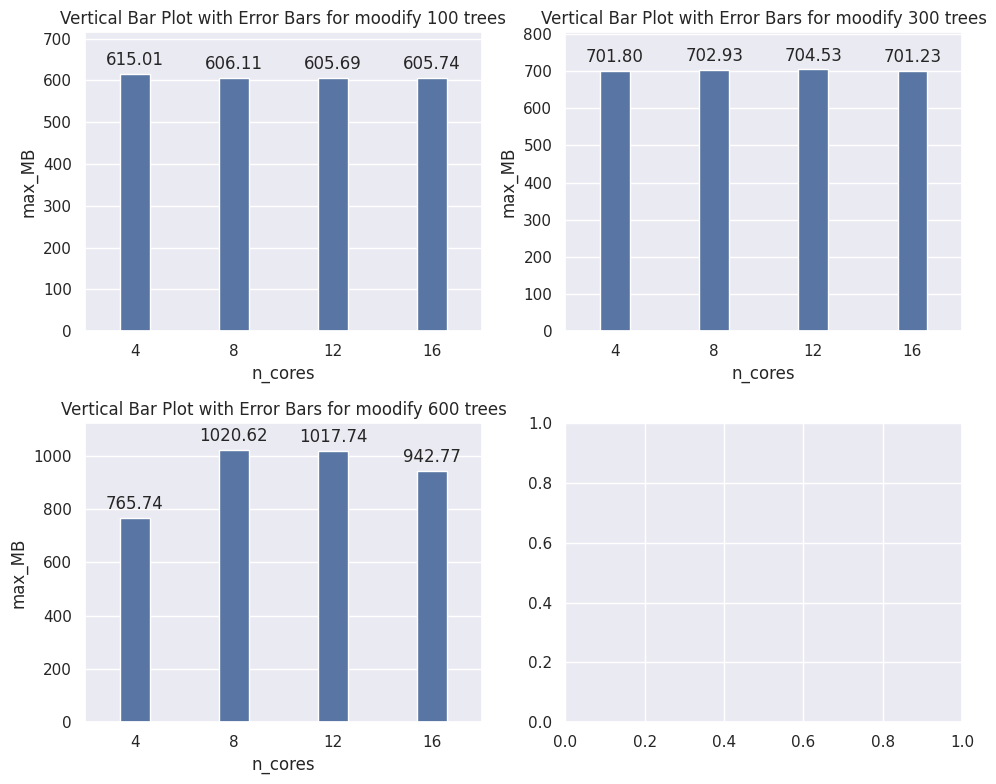

In [94]:
df=df_for_plots('moodify')
time_mem_plot('moodify',df,n_cores=[4,8,12,16],ylim_off=100)

### Plot `real_time`  vs `n_trees` for all datasets

In [ ]:
num_cores=[4,8,12,16]

for name in dataset_names:
    df=get_stats_dataset(name)
    df=df[['name','n_trees','real_time','user_time','cpu_efficiency','n_cores_fit','n_cores_importance','n_cores_anomaly']]
    df['n_cores']=[np.max(np.array([i,j,k])) for i,j,k in zip(df['n_cores_fit'],df['n_cores_importance'],df['n_cores_anomaly'])]
    df.drop(columns=['n_cores_fit','n_cores_importance','n_cores_anomaly'],inplace=True)
    df.sort_values(by='cpu_efficiency',ascending=False)
    dfs_plot=[]
    for num_core in num_cores:
        df_100=df.groupby(['n_trees','n_cores']).get_group((100,num_core))
        df_300=df.groupby(['n_trees','n_cores']).get_group((300,num_core))
        df_600=df.groupby(['n_trees','n_cores']).get_group((600,num_core))
        dfs_plot.append(pd.DataFrame({
            'n_trees': [100,300,600],
            'real_time_mean':[np.mean(df_100['real_time']),np.mean(df_300['real_time']),np.mean(df_600['real_time'])]
        }))

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    dfs = dfs_plot
    names = [f'{name} 4 cores',f'{name} 8 cores',f'{name} 12 cores',f'{name} 16 cores']

    for i, (ax, name, df) in enumerate(zip(axes.flatten(), names, dfs)):
        barplot_subplots(ax, name, df,'n_trees','real_time_mean')

    plt.tight_layout()
    plt.show()

## Plots for all datasets 

### Plot `num_samples` vs `real_time`

In [252]:
dfs_plot=[]
num_core=[8,12,16]
for num_core in num_core:
    df_100=stats.groupby(['n_trees','n_cores_fit']).get_group((100,num_core))
    df_300=stats.groupby(['n_trees','n_cores_fit']).get_group((300,num_core))
    df_600=stats.groupby(['n_trees','n_cores_fit']).get_group((600,num_core))
    dfs_plot.append(pd.DataFrame({
        'n_trees': [100,300,600],
        'real_time_mean':[np.mean(df_100['real_time']),np.mean(df_300['real_time']),np.mean(df_600['real_time'])],
        'log_real_time_mean':[np.log(np.mean(df_100['real_time'])),np.log(np.mean(df_300['real_time'])),np.log(np.mean(df_600['real_time']))]
    }))

In [255]:
df_100['num_samples']=[data_samples[name] for name in list(df_100['name'])]
df_100['log_real_time']=np.log(df_100['real_time'])
df_100['num_features']=[data_features[name] for name in list(df_100['name'])]

/tmp/ipykernel_34290/485384452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_100['num_samples']=[data_samples[name] for name in list(df_100['name'])]
/tmp/ipykernel_34290/485384452.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_100['log_real_time']=np.log(df_100['real_time'])
/tmp/ipykernel_34290/485384452.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [256]:
df_100['log_real_time']

39     5.754371
41     8.970497
44     4.052081
61     7.593457
66     5.182979
90     4.821909
108    4.346736
138    3.660377
147    5.873044
158    7.833270
172    4.753737
Name: log_real_time, dtype: float64

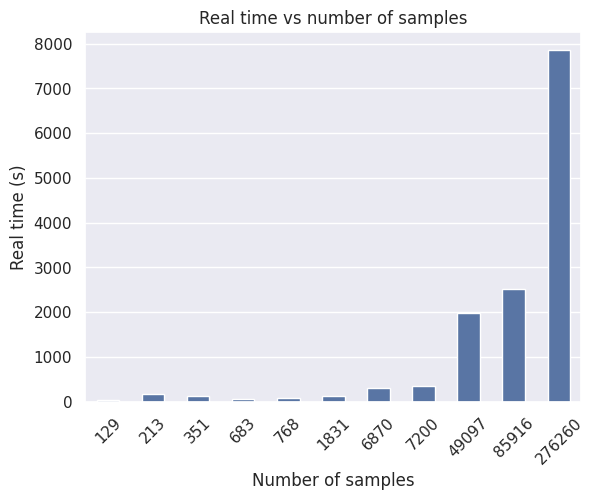

In [227]:
ax=sns.barplot(x='num_samples',y='real_time',data=df_100,width=0.5)
plt.xticks(rotation=45)
plt.xlabel('Number of samples')
plt.ylabel('Real time (s)')
plt.title('Real time vs number of samples')
plt.show()

### Plot `num_samples` vs `log_real_time`

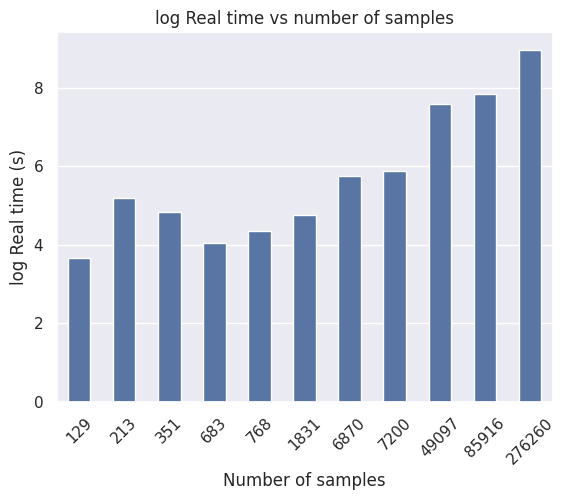

In [258]:
ax=sns.barplot(x='num_samples',y='log_real_time',data=df_100,width=0.5)
plt.xticks(rotation=45)
plt.xlabel('Number of samples')
plt.ylabel('log Real time (s)')
plt.title('log Real time vs number of samples')
plt.show()

## Experiments with all the hyperparameters combinations

We have mainly 2 hyper parameters to change in the experiments: `n_trees` and `n_cores`. We will change them in these ranges: 

- `n_trees` → [100,300,600]
- `n_cores` → [4,8,12,16]

Let's see the experiments did for all the combinations: 

- 100 trees 4 cores ->

In [3]:
from append_dir import append_dirname
append_dirname('ExIFFI')

from capri_code.process_results import load_stats, display_stats, compute_cpu_efficiency


results_dirpath = "../../container/job4/results"

stats = load_stats(results_dirpath, use_pkl=True)

for i, row in stats.iterrows():
    n_cores = max([row["n_cores_fit"], row["n_cores_importance"], row["n_cores_anomaly"]])
    stats.loc[i, "cpu_efficiency"] = compute_cpu_efficiency(row["real_time"], row["user_time"], n_cores)

display_stats(stats.sort_values(by="name", ascending=False), sort_index=False)

,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-02-01 10:11:19.319743,12,12,12,5,120,True,100,wine,5,11.119423,0.313411,337.584620,3.962561,341.925888,57.966,144.735,28.921,20.807456
2024-01-31 11:21:52.193426,4,4,4,5,120,True,100,wine,5,9.435632,0.411009,339.823493,4.797157,349.523968,49.576,136.592,13.416,68.880103
2024-02-01 21:08:15.459331,16,16,16,5,120,True,300,wine,5,19.104304,4.301442,406.377923,13.628966,422.309888,104.428,404.805,80.839,24.227518
2024-01-30 15:47:36.088014,1,1,4,5,120,True,300,wine,5,65.135395,1.783640,421.945016,3.925508,428.290048,327.901,340.537,9.254,25.963401
2024-01-30 18:04:00.427470,4,4,4,5,120,True,300,wine,5,30.545294,0.439893,442.673889,12.379361,450.551808,155.403,412.897,29.450,66.423589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-01 17:48:30.276764,4,4,4,5,120,True,600,annthyroid,5,710.476742,7.042307,750.699971,45.040282,836.046848,3554.743,13562.688,78.595,95.384448
2024-02-01 10:33:28.544486,12,12,12,5,120,True,100,annthyroid,5,130.304707,3.651595,373.656617,5.849907,382.894080,654.080,2435.787,44.116,31.033245
2024-01-31 11:35:38.451309,8,8,8,5,120,True,100,annthyroid,5,74.788019,1.545447,377.738199,3.589051,382.488576,376.111,2338.203,29.076,77.709872


### 100 trees

100 trees 4 cores

In [9]:
display_stats(stats.groupby(['n_cores_fit','n_trees']).get_group((4,100)))

,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-31 11:21:52.193426,4,4,4,5,120,True,100,wine,5,9.435632,0.411009,339.823493,4.797157,349.523968,49.576,136.592,13.416,68.880103
2024-01-31 11:23:14.895393,4,4,4,5,120,True,100,glass,5,16.065011,0.520735,366.092943,8.140177,375.205888,82.708,236.344,18.349,71.439280
2024-01-31 11:26:59.629485,4,4,4,5,120,True,100,cardio,5,44.437300,0.437698,399.578399,14.795008,420.519936,224.730,775.797,23.895,86.303231
2024-01-31 11:29:21.224044,4,4,4,5,120,True,100,pima,5,27.788584,0.815569,382.362092,11.641450,396.222464,141.434,445.083,21.908,78.673268
2024-01-31 11:30:56.431111,4,4,4,5,120,True,100,breastw,5,18.537070,0.273554,371.985121,14.615467,387.018752,95.158,284.120,19.339,74.644276
2024-01-31 11:32:36.571651,4,4,4,5,120,True,100,ionosphere,5,19.532191,0.356211,414.830264,21.005797,440.193024,100.022,290.133,23.561,72.517296
2024-01-31 11:43:09.387267,4,4,4,5,120,True,100,annthyroid,5,126.100393,2.812973,383.097078,7.249340,391.864320,632.782,2365.817,23.946,93.468880
2024-01-31 11:53:40.183025,4,4,4,5,120,True,100,pendigits,5,125.694113,1.472544,398.152663,11.527904,420.925440,630.867,2340.693,26.828,92.756992
2024-01-31 13:44:50.179968,4,4,4,5,120,True,100,diabetes,5,1333.468092,26.966386,402.566840,11.432714,419.168256,6669.827,25660.739,98.728,96.182176


100 trees 8 cores

In [10]:
display_stats(stats.groupby(['n_cores_fit','n_trees']).get_group((8,100)))

,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-31 11:22:45.456464,8,8,8,5,120,True,100,wine,5,6.294086,0.157463,343.123231,4.323091,348.299264,33.567,133.018,18.941,49.534513
2024-01-31 11:23:37.343592,8,8,8,5,120,True,100,glass,5,9.949837,0.272633,370.483855,8.293028,377.659392,51.870,227.937,23.466,54.929873
2024-01-31 11:25:50.663860,8,8,8,5,120,True,100,cardio,5,26.230811,0.527214,385.819116,5.178153,393.211904,133.281,756.082,28.589,70.910520
2024-01-31 11:27:13.970827,8,8,8,5,120,True,100,pima,5,16.234695,0.146628,379.498988,11.312443,389.828608,84.015,430.135,25.851,63.996757
2024-01-31 11:28:18.782890,8,8,8,5,120,True,100,breastw,5,11.315375,0.231621,365.879296,7.114440,374.640640,62.605,273.027,24.298,54.513817
2024-01-31 11:29:22.224695,8,8,8,5,120,True,100,ionosphere,5,12.209009,0.255528,384.849019,9.458180,403.341312,63.494,277.242,30.021,54.580354
2024-01-31 11:35:38.451309,8,8,8,5,120,True,100,annthyroid,5,74.788019,1.545447,377.738199,3.589051,382.488576,376.111,2338.203,29.076,77.709872
2024-01-31 11:42:04.451673,8,8,8,5,120,True,100,pendigits,5,76.724382,0.813368,395.282678,9.007359,408.944640,385.980,2363.045,35.759,76.527443
2024-01-31 12:47:43.895729,8,8,8,5,120,True,100,diabetes,5,787.412336,13.644197,400.941384,8.315599,412.463104,3939.523,25865.904,53.659,82.071814


100 trees 12 cores

In [11]:
display_stats(stats.groupby(['n_cores_fit','n_trees']).get_group((12,100)))

,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-02-01 10:11:19.319743,12,12,12,5,120,True,100,wine,5,11.119423,0.313411,337.584620,3.962561,341.925888,57.966,144.735,28.921,20.807456
2024-02-01 10:12:48.857597,12,12,12,5,120,True,100,glass,5,17.403065,0.542615,363.112858,4.969287,371.642368,89.530,249.076,36.691,23.183663
2024-02-01 10:16:40.806685,12,12,12,5,120,True,100,cardio,5,45.872774,0.386025,383.394775,6.846050,396.738560,232.039,800.959,42.784,28.765243
2024-02-01 10:19:06.915117,12,12,12,5,120,True,100,pima,5,28.631713,0.217155,380.755640,7.942407,389.853184,145.858,458.024,40.836,26.168374
2024-02-01 10:20:47.203957,12,12,12,5,120,True,100,breastw,5,19.511130,0.266380,372.095877,7.059444,378.449920,100.224,290.490,39.246,24.153396
2024-02-01 10:22:34.397214,12,12,12,5,120,True,100,ionosphere,5,20.910907,0.618325,377.636946,8.936174,398.929920,107.189,298.937,42.470,23.240647
2024-02-01 10:33:28.544486,12,12,12,5,120,True,100,annthyroid,5,130.304707,3.651595,373.656617,5.849907,382.894080,654.080,2435.787,44.116,31.033245
2024-02-01 10:44:16.298571,12,12,12,5,120,True,100,pendigits,5,128.994907,1.172770,386.928968,8.449247,397.332480,647.829,2411.146,51.599,31.015721
2024-02-01 12:41:03.831086,12,12,12,5,120,True,100,diabetes,5,1400.954926,33.288913,449.832878,24.290105,508.342272,7007.507,26850.985,92.783,31.931214


100 trees 16 cores

In [12]:
display_stats(stats.groupby(['n_cores_fit','n_trees']).get_group((16,100)))

,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-02-01 17:18:27.650327,16,16,16,5,120,True,100,wine,5,7.192660,0.274424,335.476654,4.587002,341.868544,38.876,139.585,48.741,22.440741
2024-02-01 17:21:25.765919,16,16,16,5,120,True,100,glass,5,34.837995,19.219641,367.888630,6.877677,373.293056,178.213,247.891,61.237,8.693635
2024-02-01 17:23:21.611890,16,16,16,5,120,True,100,cardio,5,22.532630,0.734738,396.360745,6.870839,402.505728,116.017,775.589,75.482,41.782077
2024-02-01 17:24:39.075311,16,16,16,5,120,True,100,pima,5,14.824869,0.266681,372.047053,6.853155,379.342848,77.226,444.449,64.250,35.969832
2024-02-01 17:25:36.926624,16,16,16,5,120,True,100,breastw,5,10.942151,0.320736,363.635180,9.017367,372.936704,57.517,280.346,53.859,30.463385
2024-02-01 17:27:41.060949,16,16,16,5,120,True,100,ionosphere,5,24.208145,18.022452,377.583534,9.093787,389.468160,124.202,292.390,70.589,14.713431
2024-02-01 17:33:36.307595,16,16,16,5,120,True,100,annthyroid,5,70.482182,14.392423,374.170911,2.983161,376.942592,355.329,2377.048,86.758,41.810688
2024-02-01 17:38:52.052193,16,16,16,5,120,True,100,pendigits,5,62.512172,7.449254,385.564836,6.326381,395.579392,315.567,2353.140,82.578,46.605396
2024-02-01 18:20:55.319104,16,16,16,5,120,True,100,diabetes,5,504.023221,19.079951,486.918226,35.317060,571.260928,2523.167,25491.474,129.811,63.143546


### 300 trees

300 trees 4 cores

In [17]:
display_stats(stats.groupby(['n_cores_fit','n_trees']).get_group((4,300)))

,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-30 15:35:08.255912,4,1,1,5,120,True,300,wine,5,36.076435,0.999008,443.505377,11.205296,466.964480,182.849,347.223,10.888,47.474009
2024-01-30 15:40:41.691636,4,1,1,5,120,True,300,glass,5,65.843605,0.978784,421.421711,24.829751,494.878720,331.750,615.674,14.859,46.395931
2024-01-30 16:50:32.736658,4,1,1,5,120,True,300,cardio,5,380.160016,1.962829,736.371671,33.649745,762.687488,1908.615,2271.178,24.292,29.749033
2024-01-30 18:04:00.427470,4,4,4,5,120,True,300,wine,5,30.545294,0.439893,442.673889,12.379361,450.551808,155.403,412.897,29.450,66.423589
2024-01-30 18:08:17.140138,4,4,4,5,120,True,300,glass,5,50.799305,0.744255,528.016835,21.841332,538.071040,257.075,726.041,41.006,70.605952
2024-01-30 18:20:54.680314,4,4,4,5,120,True,300,cardio,5,150.260168,1.874259,633.598607,27.550300,651.247616,757.341,2450.098,59.949,80.878297
2024-01-30 19:34:29.794001,4,4,4,5,120,True,300,wine,5,36.091074,6.986208,442.984202,10.987222,450.961408,184.554,411.978,35.911,55.807243
2024-01-30 19:38:40.374176,4,4,4,5,120,True,300,glass,5,49.253900,1.624285,517.520425,20.473205,536.113152,248.956,698.099,45.292,70.102649
2024-01-30 19:50:03.422493,4,4,4,5,120,True,300,cardio,5,136.002594,2.305052,632.747950,29.538196,647.999488,683.232,2324.940,65.379,85.071396


In [17]:
stats.groupby(['n_cores_fit','n_trees']).get_group((4,300))['name'].unique()

array(['pendigits', 'wine', 'glass', 'cardio', 'ionosphere', 'annthyroid',
       'diabetes', 'breastw', 'pima'], dtype=object)

300 trees 8 cores

In [18]:
display_stats(stats.groupby(['n_cores_fit','n_trees']).get_group((8,300)))

,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-31 16:51:23.874894,8,8,8,5,120,True,300,wine,5,19.905357,0.531305,415.790203,9.180716,427.474944,101.985,396.454,37.245,48.592195
2024-01-31 16:54:07.861224,8,8,8,5,120,True,300,glass,5,32.305612,0.659922,481.969439,15.419922,505.745408,164.049,697.476,50.247,53.145402
2024-01-31 17:00:59.660310,8,8,8,5,120,True,300,cardio,5,81.847115,1.072554,580.731372,27.621478,626.106368,411.823,2322.534,65.316,70.495516
2024-01-31 17:05:15.620974,8,8,8,5,120,True,300,pima,5,50.678049,0.883840,524.159386,26.828166,551.870464,256.204,1287.064,58.299,62.794882
2024-01-31 17:08:21.215276,8,8,8,5,120,True,300,breastw,5,36.546677,0.675259,495.119892,15.776448,519.327744,185.184,826.016,51.602,55.756437
2024-01-31 17:11:37.220612,8,8,8,5,120,True,300,ionosphere,5,38.706381,0.507393,578.154988,32.685786,618.020864,195.960,845.564,62.045,53.937283
2024-01-31 17:29:46.391486,8,8,8,5,120,True,300,annthyroid,5,217.337070,2.501002,523.667210,24.805085,556.199936,1089.453,7003.658,60.854,80.357505
2024-01-31 17:48:20.883909,8,8,8,5,120,True,300,pendigits,5,222.336998,2.295969,560.668836,27.147229,593.149952,1114.180,7036.678,74.978,78.944583
2024-01-31 20:54:32.866041,8,8,8,5,120,True,300,diabetes,5,2233.866665,47.068060,532.672512,23.406415,570.601472,11171.858,77912.916,96.742,87.175423


300 trees 12 cores

In [3]:
display_stats(stats.groupby(['n_cores_fit','n_trees']).get_group((12,300)))

,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-02-04 11:51:02.821895,12,12,12,5,120,True,300,wine,5,16.114013,0.478471,414.420500,7.866357,422.793216,83.080,406.923,52.425,40.816382
2024-02-04 11:53:16.820744,12,12,12,5,120,True,300,glass,5,26.296648,0.498834,459.188306,11.690259,481.202176,134.573,716.546,69.733,44.371580
2024-02-04 11:58:26.423000,12,12,12,5,120,True,300,cardio,5,61.293012,0.310087,544.853688,29.558082,592.920576,308.991,2384.341,93.352,64.304489
2024-02-04 12:01:45.594327,12,12,12,5,120,True,300,pima,5,39.322265,0.313105,482.827141,16.155625,511.250432,199.027,1310.620,77.226,54.876139
2024-02-04 12:04:13.154109,12,12,12,5,120,True,300,breastw,5,29.034996,0.428471,465.289708,18.307873,507.379712,147.615,842.515,70.999,47.562635
2024-02-04 12:06:55.897179,12,12,12,5,120,True,300,ionosphere,5,32.030859,0.193419,544.543048,33.367675,616.304640,162.632,871.587,82.892,44.660491
2024-02-04 12:19:55.755309,12,12,12,5,120,True,300,annthyroid,5,155.481778,1.389864,498.125210,17.368621,531.947520,780.435,7156.231,93.439,76.412845
2024-02-04 12:33:12.704821,12,12,12,5,120,True,300,pendigits,5,158.783646,0.923899,546.481439,24.925108,584.949760,796.845,7301.124,106.573,76.354498
2024-02-04 14:47:49.509624,12,12,12,5,120,True,300,diabetes,5,1614.745856,27.761487,552.492892,32.157856,595.644416,8076.812,78744.195,141.248,81.245128


300 trees 16 cores

In [25]:
display_stats(stats.groupby(['n_cores_fit','n_trees']).get_group((16,300)))

,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-02-01 21:08:15.459331,16,16,16,5,120,True,300,wine,5,19.104304,4.301442,406.377923,13.628966,422.309888,104.428,404.805,80.839,24.227518
2024-02-01 21:10:32.943421,16,16,16,5,120,True,300,glass,5,26.405872,1.345835,484.922327,21.790835,502.587392,137.766,698.341,101.505,31.681483
2024-02-01 21:18:12.396159,16,16,16,5,120,True,300,cardio,5,89.180275,29.619100,539.703378,33.294741,589.414400,456.755,2342.715,147.758,32.056505
2024-02-01 21:21:29.706524,16,16,16,5,120,True,300,pima,5,38.741157,0.954184,480.323666,23.376552,516.919296,197.092,1289.727,105.600,40.898635
2024-02-01 21:24:00.316622,16,16,16,5,120,True,300,breastw,5,28.568222,0.504543,487.481508,17.911572,502.476800,148.775,831.685,100.724,34.938876
2024-02-01 21:28:19.383859,16,16,16,5,120,True,300,ionosphere,5,50.883176,27.029136,571.329905,27.017734,596.078592,260.792,871.948,131.262,20.896634
2024-02-01 21:41:26.443917,16,16,16,5,120,True,300,annthyroid,5,153.937974,3.129251,509.161472,19.152141,534.097920,783.486,7023.651,139.748,56.028849
2024-02-01 21:54:16.156182,16,16,16,5,120,True,300,pendigits,5,151.058671,3.392317,536.498012,19.705095,551.481344,767.125,7137.036,152.888,58.147597
2024-02-01 23:56:28.981489,16,16,16,5,120,True,300,diabetes,5,1465.913736,17.766902,531.139953,36.517184,592.334848,7332.245,75617.603,180.773,64.456387


### 600 trees

600 trees 4 cores 

In [10]:
display_stats(stats.groupby(['n_cores_fit','n_trees']).get_group((4,600)))

,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-02-01 15:51:16.138901,4,4,4,5,120,True,600,wine,5,49.464867,0.349339,511.345787,16.058745,535.826432,249.581,750.088,38.894,75.134726
2024-02-01 15:58:24.053713,4,4,4,5,120,True,600,glass,5,85.132125,0.914867,701.683630,49.974667,755.003392,427.939,1317.405,60.576,76.962196
2024-02-01 16:19:23.388798,4,4,4,5,120,True,600,cardio,5,251.397923,1.426563,914.855690,83.472653,1050.021888,1259.353,4492.840,84.946,89.189449
2024-02-01 16:32:02.766173,4,4,4,5,120,True,600,pima,5,151.395927,1.269479,788.958577,49.313546,847.175680,759.339,2559.266,72.424,84.259665
2024-02-01 16:40:20.947580,4,4,4,5,120,True,600,breastw,5,99.154806,0.772228,751.504916,38.401367,788.066304,498.135,1574.577,66.429,79.023608
2024-02-01 16:49:15.450671,4,4,4,5,120,True,600,ionosphere,5,106.419593,1.097300,953.386762,68.155357,1038.114816,534.503,1634.636,86.648,76.455885
2024-02-01 17:48:30.276764,4,4,4,5,120,True,600,annthyroid,5,710.476742,7.042307,750.699971,45.040282,836.046848,3554.743,13562.688,78.595,95.384448
2024-02-01 18:48:47.918016,4,4,4,5,120,True,600,pendigits,5,723.049519,8.953538,843.452580,66.350733,970.264576,3617.626,13739.772,97.214,94.950197
2024-02-02 05:28:14.844389,4,4,4,5,120,True,600,diabetes,5,7672.599338,86.944618,810.237460,36.569624,861.380608,38366.913,149597.100,116.983,97.477936


600 trees 8 cores 

In [19]:
display_stats(stats.groupby(['n_cores_fit','n_trees']).get_group((8,600)))

,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-02-01 15:52:26.376258,8,8,8,5,120,True,600,wine,5,44.955647,1.088962,510.195139,35.109597,551.968768,227.337,768.860,54.494,42.275345
2024-02-01 15:58:30.373970,8,8,8,5,120,True,600,glass,5,72.276890,3.267857,633.936282,51.088278,712.134656,364.367,1397.053,98.353,47.927399
2024-02-01 16:15:48.462998,8,8,8,5,120,True,600,cardio,5,207.012391,7.777765,896.135168,49.086829,955.617280,1037.990,4637.711,130.699,55.849659
2024-02-01 16:26:06.960913,8,8,8,5,120,True,600,pima,5,123.097834,5.920697,752.612639,35.882165,800.944128,618.170,2581.669,110.239,52.203864
2024-02-01 16:33:15.296250,8,8,8,5,120,True,600,breastw,5,85.133493,3.883021,691.231293,42.641750,735.621120,428.659,1645.675,97.411,47.989048
2024-02-01 16:40:15.800527,8,8,8,5,120,True,600,ionosphere,5,83.489353,1.567177,827.624489,79.117245,918.425600,420.590,1754.487,132.469,52.143626
2024-02-01 17:15:53.874166,8,8,8,5,120,True,600,annthyroid,5,426.972729,16.930864,759.206380,48.083987,809.615360,2137.944,14271.069,140.492,83.439212
2024-02-01 17:54:13.179307,8,8,8,5,120,True,600,pendigits,5,459.235248,20.146844,829.226353,64.250379,926.969856,2298.918,14171.621,149.661,77.055929
2024-02-01 23:35:55.396725,8,8,8,5,120,True,600,diabetes,5,4099.882489,78.624308,758.297887,41.881168,790.196224,20502.224,153337.181,181.973,93.488139


600 trees 12 cores

In [4]:
display_stats(stats.groupby(['n_cores_fit','n_trees']).get_group((12,600)))

,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-02-04 11:54:40.241889,12,12,12,5,120,True,600,wine,5,26.191511,0.254415,503.800791,29.787922,542.588928,133.154,745.287,68.728,46.643173
2024-02-04 11:58:27.341694,12,12,12,5,120,True,600,glass,5,44.973034,0.499442,610.251244,32.825007,659.169280,227.133,1321.252,94.035,48.475710
2024-02-04 12:07:29.182758,12,12,12,5,120,True,600,cardio,5,107.908316,1.004530,753.662198,15.491370,771.592192,541.970,4519.638,127.226,69.493976
2024-02-04 12:13:35.689343,12,12,12,5,120,True,600,pima,5,71.902974,0.788246,713.800417,46.593756,793.374720,364.872,2546.671,110.909,58.163571
2024-02-04 12:17:53.423776,12,12,12,5,120,True,600,breastw,5,51.064737,0.640846,664.883200,59.701350,724.914176,257.659,1584.070,98.603,51.232766
2024-02-04 12:22:41.549017,12,12,12,5,120,True,600,ionosphere,5,57.147201,0.763849,709.305795,73.943648,889.724928,288.117,1644.778,123.240,47.572630
2024-02-04 12:44:36.569257,12,12,12,5,120,True,600,annthyroid,5,262.517505,3.191792,700.584100,34.159520,770.400256,1314.930,13741.861,120.265,87.088673
2024-02-04 13:06:29.712683,12,12,12,5,120,True,600,pendigits,5,262.159845,2.365630,730.285670,32.926138,786.714624,1313.127,13581.187,138.723,86.188585
2024-02-04 16:52:22.271864,12,12,12,5,120,True,600,diabetes,5,2710.026759,30.882465,737.759724,34.037162,773.652480,13552.625,153164.436,177.067,94.178825


600 trees 16 cores

In [21]:
display_stats(stats.groupby(['n_cores_fit','n_trees']).get_group((16,600)))

,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-02-02 00:10:40.415865,16,16,16,5,120,True,600,wine,5,27.252702,0.894282,500.079165,30.194898,534.003712,138.569,769.268,97.232,34.696974
2024-02-02 00:15:07.102419,16,16,16,5,120,True,600,glass,5,52.871927,15.738204,644.753326,34.386758,707.469312,266.783,1364.385,146.932,31.963829
2024-02-02 00:24:43.321305,16,16,16,5,120,True,600,cardio,5,114.722912,22.921076,802.950513,62.784805,891.219968,576.953,4592.786,208.048,49.752601
2024-02-02 00:30:42.398142,16,16,16,5,120,True,600,pima,5,71.115155,2.467598,706.663547,45.792680,766.443520,358.341,2639.785,164.085,46.041777
2024-02-02 00:34:44.045345,16,16,16,5,120,True,600,breastw,5,47.798469,0.609341,643.835331,49.007436,703.332352,241.448,1631.697,137.178,42.237278
2024-02-02 00:42:31.083728,16,16,16,5,120,True,600,ionosphere,5,92.801295,28.101781,807.002604,80.707712,906.493952,468.470,1754.693,218.817,23.409890
2024-02-02 01:02:11.144927,16,16,16,5,120,True,600,annthyroid,5,235.205769,5.894885,711.268598,29.236238,768.081920,1178.606,14062.948,182.522,74.574052
2024-02-02 01:26:49.987086,16,16,16,5,120,True,600,pendigits,5,295.129309,40.281138,815.978906,62.165013,881.807360,1479.023,14295.813,290.159,60.410711
2024-02-06 13:59:10.226473,16,16,16,5,120,True,600,diabetes,5,2233.109947,17.170841,703.994429,28.860667,760.442880,11169.609,153305.581,350.872,85.782759


## Compute Speedup and Efficiency

In [105]:
results_dirpath = "../../container/job4/results/"

stats = load_stats(results_dirpath, use_pkl=True)

for i, row in stats.iterrows():
    n_cores = max([row["n_cores_fit"], row["n_cores_importance"], row["n_cores_anomaly"]])
    stats.loc[i, "cpu_efficiency"] = compute_cpu_efficiency(row["real_time"], row["user_time"], n_cores)

### Wine

In [109]:
display_stats(stats.groupby('name').get_group('wine'))

,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-01-30 15:34:38.531939,1,1,1,5,120,False,100,wine,5,22.670529,1.310402,326.859817,7.030727,333.770752,120.767,113.376,0.583,93.879951
2024-01-30 15:35:08.255912,4,1,1,5,120,True,300,wine,5,36.076435,0.999008,443.505377,11.205296,466.964480,182.849,347.223,10.888,47.474009
2024-01-30 15:47:36.088014,1,1,4,5,120,True,300,wine,5,65.135395,1.783640,421.945016,3.925508,428.290048,327.901,340.537,9.254,25.963401
2024-01-30 16:22:03.105891,1,1,1,5,120,False,300,wine,5,65.463616,4.144099,404.238664,2.465636,407.486464,329.567,327.989,1.480,99.521190
2024-01-30 18:04:00.427470,4,4,4,5,120,True,300,wine,5,30.545294,0.439893,442.673889,12.379361,450.551808,155.403,412.897,29.450,66.423589
2024-01-30 19:34:29.794001,4,4,4,5,120,True,300,wine,5,36.091074,6.986208,442.984202,10.987222,450.961408,184.554,411.978,35.911,55.807243
2024-01-31 11:17:17.762289,1,1,4,5,120,True,100,wine,5,22.900842,0.509877,339.171738,1.148610,341.471232,117.104,118.939,5.572,25.391746
2024-01-31 11:21:52.193426,4,4,4,5,120,True,100,wine,5,9.435632,0.411009,339.823493,4.797157,349.523968,49.576,136.592,13.416,68.880103
2024-01-31 11:22:45.456464,8,8,8,5,120,True,100,wine,5,6.294086,0.157463,343.123231,4.323091,348.299264,33.567,133.018,18.941,49.534513


### 100 trees

In [126]:
df=stats.groupby(['name',"n_trees"]).get_group(('wine',100))
df['n_cores']=[np.max(np.array([i,j,k])) for i,j,k in zip(df['n_cores_fit'],df['n_cores_importance'],df['n_cores_anomaly'])]
serial_time=float(df[df['parallel']==False]['real_time'])
df['Speedup']=df['real_time']/serial_time
df['1/Speedup']=serial_time/df['real_time']
df['Efficiency']=df['Speedup']/df['n_cores']
df=df[['name','n_trees','n_cores','Speedup','1/Speedup','Efficiency']]
df

/tmp/ipykernel_8918/1665553493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_cores']=[np.max(np.array([i,j,k])) for i,j,k in zip(df['n_cores_fit'],df['n_cores_importance'],df['n_cores_anomaly'])]
/tmp/ipykernel_8918/1665553493.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Speedup']=df['real_time']/serial_time
/tmp/ipykernel_8918/1665553493.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

,name,n_trees,n_cores,Speedup,1/Speedup,Efficiency
4,wine,100,1,1.000000,1.000000,1.000000
16,wine,100,4,0.969669,1.031280,0.242417
21,wine,100,8,0.277948,3.597789,0.034744
61,wine,100,4,0.410509,2.435997,0.102627


The easier conclusion here is that with 8 cores we are more than 3 times faster than the serial version and with 4 cores we are more than 2 times faster. 

### 300 trees

In [127]:
df=stats.groupby(['name',"n_trees"]).get_group(('wine',300))
df['n_cores']=[np.max(np.array([i,j,k])) for i,j,k in zip(df['n_cores_fit'],df['n_cores_importance'],df['n_cores_anomaly'])]
serial_time=float(df[df['parallel']==False]['real_time'])
df['Speedup']=df['real_time']/serial_time
df['1/Speedup']=serial_time/df['real_time']
df['Efficiency']=df['Speedup']/df['n_cores']
df=df[['name','n_trees','n_cores','Speedup','1/Speedup','Efficiency']]
df

/tmp/ipykernel_8918/1396246683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_cores']=[np.max(np.array([i,j,k])) for i,j,k in zip(df['n_cores_fit'],df['n_cores_importance'],df['n_cores_anomaly'])]
/tmp/ipykernel_8918/1396246683.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Speedup']=df['real_time']/serial_time
/tmp/ipykernel_8918/1396246683.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

,name,n_trees,n_cores,Speedup,1/Speedup,Efficiency
8,wine,300,4,0.559989,1.785748,0.139997
17,wine,300,4,0.994945,1.005081,0.248736
34,wine,300,8,0.309451,3.231524,0.038681
38,wine,300,4,0.554816,1.802400,0.138704
60,wine,300,1,1.000000,1.000000,1.000000
66,wine,300,4,0.471537,2.120725,0.117884


### Glass

#### 100 trees

In [133]:
df=stats.groupby(['name','n_trees']).get_group(('glass',100))
df['n_cores']=[np.max(np.array([i,j,k])) for i,j,k in zip(df['n_cores_fit'],df['n_cores_importance'],df['n_cores_anomaly'])]
serial_time=float(df[df['parallel']==False]['real_time'])
df['Speedup']=df['real_time']/serial_time
df['1/Speedup']=serial_time/df['real_time']
df['Efficiency']=df['Speedup']/df['n_cores']
df=df[['name','n_trees','n_cores','Speedup','1/Speedup','Efficiency']]
df

/tmp/ipykernel_8918/3052569487.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_cores']=[np.max(np.array([i,j,k])) for i,j,k in zip(df['n_cores_fit'],df['n_cores_importance'],df['n_cores_anomaly'])]
/tmp/ipykernel_8918/3052569487.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Speedup']=df['real_time']/serial_time
/tmp/ipykernel_8918/3052569487.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

,name,n_trees,n_cores,Speedup,1/Speedup,Efficiency
18,glass,100,1,1.000000,1.000000,1.000000
52,glass,100,8,0.260271,3.842144,0.032534
62,glass,100,4,0.415009,2.409586,0.103752


#### 300 trees

In [132]:
df=stats.groupby(['name','n_trees']).get_group(('glass',300))
df['n_cores']=[np.max(np.array([i,j,k])) for i,j,k in zip(df['n_cores_fit'],df['n_cores_importance'],df['n_cores_anomaly'])]
serial_time=float(df[df['parallel']==False]['real_time'])
df['Speedup']=df['real_time']/serial_time
df['1/Speedup']=serial_time/df['real_time']
df['Efficiency']=df['Speedup']/df['n_cores']
df=df[['name','n_trees','n_cores','Speedup','1/Speedup','Efficiency']]
df

/tmp/ipykernel_8918/544743139.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_cores']=[np.max(np.array([i,j,k])) for i,j,k in zip(df['n_cores_fit'],df['n_cores_importance'],df['n_cores_anomaly'])]
/tmp/ipykernel_8918/544743139.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Speedup']=df['real_time']/serial_time
/tmp/ipykernel_8918/544743139.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

,name,n_trees,n_cores,Speedup,1/Speedup,Efficiency
2,glass,300,4,1.035041,0.966145,0.258760
5,glass,300,1,1.000000,1.000000,1.000000
12,glass,300,4,0.445682,2.243750,0.111421
40,glass,300,8,0.293681,3.405050,0.036710
48,glass,300,4,0.460217,2.172887,0.115054
69,glass,300,4,0.593901,1.683783,0.148475


## Memory Experiments Results

In [41]:
from append_dir import append_dirname
append_dirname('ExIFFI')

from capri_code.process_results import load_stats, display_stats, compute_cpu_efficiency


results_dirpath = "../../container/job5/results/"

stats = load_stats(results_dirpath, use_pkl=True)

for i, row in stats.iterrows():
    n_cores = max([row["n_cores_fit"], row["n_cores_importance"], row["n_cores_anomaly"]])
    stats.loc[i, "cpu_efficiency"] = compute_cpu_efficiency(row["real_time"], row["user_time"], n_cores)
    
display_stats(stats.sort_values(by="name", ascending=False), sort_index=False)

,n_cores_fit,n_cores_importance,n_cores_anomaly,n_runs,seed,parallel,n_trees,name,n_runs_imps,mean_time,std_time,mean_MB,std_MB,max_MB,real_time,user_time,sys_time,cpu_efficiency
time,,,,,,,,,,,,,,,,,,
2024-02-10 08:10:35.747705,1,1,1,1,120,False,100,wine,1,4.451197,0.0,332.070912,0.0,332.070912,6.897,6.376,0.388,92.445991
2024-02-06 18:18:28.336223,4,4,4,1,120,True,100,wine,1,3.503518,0.0,327.827456,0.0,327.827456,6.455,8.978,1.491,34.771495
